In [1]:
"""
Predict albedo and shading layer of an input image.
"""

import os
import sys
sys.path.append('./util')
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

__author__ = "Udo Dehm"
__copyright__ = "Copyright 2017"
__credits__ = ["Udo Dehm"]
__license__ = ""
__version__ = "0.1"
__maintainer__ = "Udo Dehm"
__email__ = "udo.dehm@mailbox.org"
__status__ = "Development"

In [2]:
def import_data(data_directory):
    dfs_train = {}
    dfs_valid = {}
    for file in os.listdir(data_directory):
        df_name = 'df_' + file[10:-4].replace('loss_', '').replace('_1', '').replace('invariant', 'inv')
        if 'valid' in file:
            df_name = df_name.replace('valid_', '')
            dfs_valid[df_name] = pd.read_csv(filepath_or_buffer=data_directory + file)
            dfs_valid[df_name].columns = dfs_valid[df_name].columns.str.replace(" ", "_").str.lower()
            dfs_valid[df_name]['wall_time'] = pd.to_datetime(dfs_valid[df_name]['wall_time'],unit='s')
        else:
            df_name = df_name.replace('_loss', '')
            if '_lambda' in df_name:
                df_name = df_name[:df_name.find('_lambda')]
            dfs_train[df_name] = pd.read_csv(filepath_or_buffer=data_directory + file)
            dfs_train[df_name].columns = dfs_train[df_name].columns.str.replace(" ", "_").str.lower()
            dfs_train[df_name]['wall_time'] = pd.to_datetime(dfs_train[df_name]['wall_time'],unit='s')
    return dfs_train, dfs_valid


def plot_all_loss_pairs(dfs_train, dfs_valid, logy=False, ylim_scale=5):
    for key in dfs_train:
        fig = plt.figure
        ax = dfs_train[key].plot(x='step', y='value', figsize=(12,7), 
                                 fontsize=14, legend=True, style='-o',
                                 title=key[3:], logy=logy)
        dfs_valid[key].plot(x='step', y='value', style='-o', ax=ax)
        ax.set_xlabel('step')
        ax.set_ylabel('loss')
        plt.ylim(0,ylim_scale*dfs_train[key]['value'].max())
        ax.legend(["training set", "validation set"], prop={'size': 14})
        # plt.savefig('foo.png', bbox_inches='tight')


def get_all_loss_model_data(data_dir, exclude_sub_dirs=[]):
    dfs_train = {}
    dfs_valid = {}
    dirs = [x for x in sorted(os.listdir(data_dir)) if x not in exclude_sub_dirs]
    for direc in dirs:
        dict_train, dict_valid = import_data(data_directory=data_dir + '/' + direc + '/')
        for key in dict_train:
            if key not in dfs_train:
                dfs_train[key] = pd.DataFrame()
                dfs_valid[key] = pd.DataFrame()
            dfs_train[key] = dfs_train[key].append(dict_train[key], ignore_index=True)
            dfs_valid[key] = dfs_valid[key].append(dict_valid[key], ignore_index=True)
    return dfs_train, dfs_valid


def get_minimum_loss(dfdict_train, dfdict_valid):
    print('Training loss:')
    for key, df in dfdict_train.items():
        minstep = df.loc[df['value'].idxmin(),'step']
        cor_valloss = dfdict_valid[key].loc[(dfdict_valid[key]['step'] - minstep).abs().idxmin()][['step', 'value']]
        print('{dfname} (step: {step}): {minloss:.5f} <-> corresponding valid loss: {valloss:.5f} (step: {valstep})'.format(dfname=key,
                                                              minloss=df['value'].min(),
                                                              step=minstep,
                                                              valloss=cor_valloss['value'],
                                                              valstep=cor_valloss['step']))
    print('\nValidation loss:')
    for key, df in dfdict_valid.items():
        minstep = df.loc[df['value'].idxmin(),'step']
        cor_trainloss = dfdict_train[key].loc[(dfdict_train[key]['step'] - minstep).abs().idxmin()][['step', 'value']]
        print('{dfname} (step: {step}): {minloss:.5f} <-> corresponding train loss: {trainloss:.5f} (step: {trainstep})'.format(dfname=key,
                                                              minloss=df['value'].min(),
                                                              step=minstep,
                                                              trainloss=cor_trainloss['value'],
                                                              trainstep=cor_trainloss['step']))


In [3]:
logs_data_path = '/home/udo/image_decomposition/logs/logs_data/'

# Sintel:

In [4]:
logs_data_path_sintel = logs_data_path + 'sintel/'

## Resnet-50 narihira2015 (2 scale, reduced parameters):

Training loss:
df_l1 (step: 16800): 0.04608 <-> corresponding valid loss: 0.29806 (step: 16813)
df_l2 (step: 16800): 0.00288 <-> corresponding valid loss: 0.07154 (step: 16813)
df_l2_inv (step: 16800): 0.00182 <-> corresponding valid loss: 0.02415 (step: 16813)
df_berhu (step: 16800): 0.04656 <-> corresponding valid loss: 0.33021 (step: 16813)
df_l2_avg (step: 16800): 0.00235 <-> corresponding valid loss: 0.04785 (step: 16813)

Validation loss:
df_l1 (step: 4300): 0.25791 <-> corresponding train loss: 0.07706 (step: 4300)
df_l2 (step: 4300): 0.05532 <-> corresponding train loss: 0.00699 (step: 4300)
df_l2_inv (step: 4300): 0.02035 <-> corresponding train loss: 0.00400 (step: 4300)
df_berhu (step: 4300): 0.28354 <-> corresponding train loss: 0.07787 (step: 4300)
df_l2_avg (step: 4300): 0.03783 <-> corresponding train loss: 0.00550 (step: 4300)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


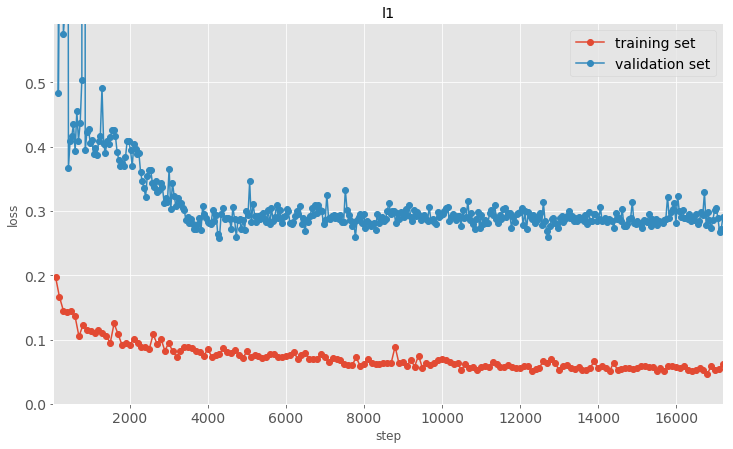

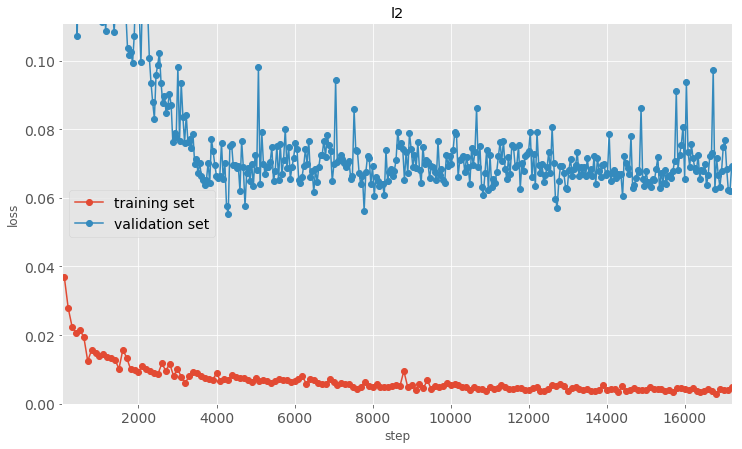

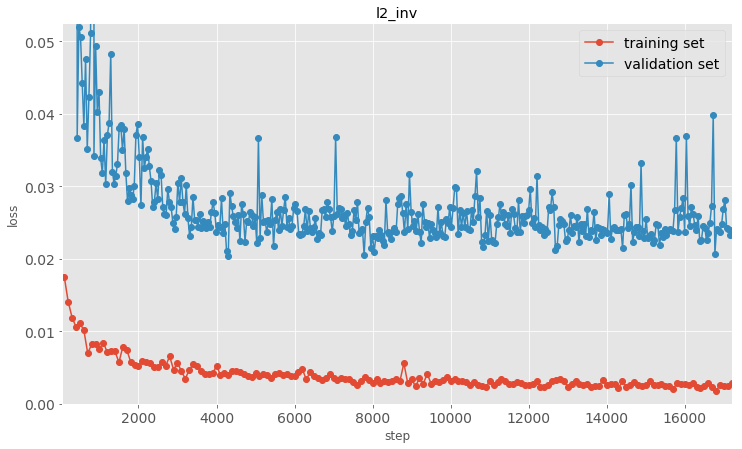

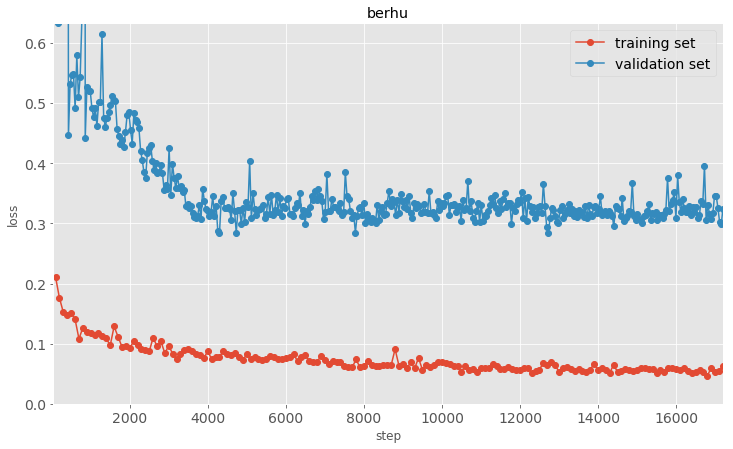

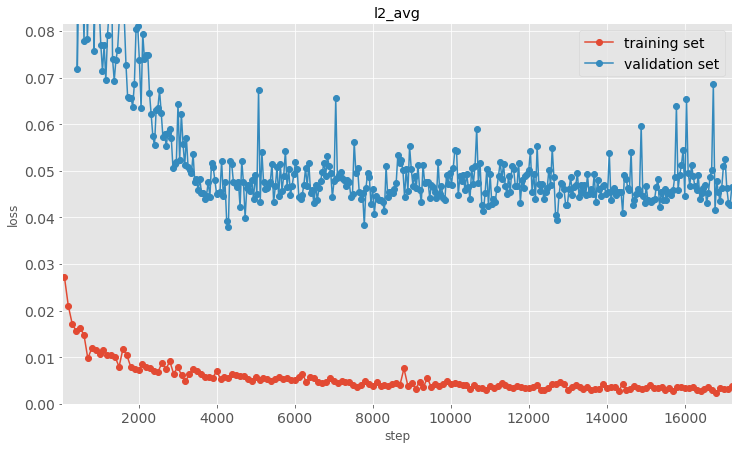

In [26]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_narihira2015_reduced')
dfs_train_resnet_v1_50_narihira2015_reduced, dfs_valid_resnet_v1_50_narihira2015_reduced = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_narihira2015_reduced,
                 dfdict_valid=dfs_valid_resnet_v1_50_narihira2015_reduced)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_narihira2015_reduced, 
                    dfs_valid=dfs_valid_resnet_v1_50_narihira2015_reduced, logy=False, ylim_scale=3)

## Resnet-50 deconv decoder (1 scale, reduced parameters):

Training loss:
df_l1 (step: 16600): 0.06813 <-> corresponding valid loss: 0.28823 (step: 16598)
df_l2 (step: 16600): 0.00664 <-> corresponding valid loss: 0.06720 (step: 16598)
df_l2_inv (step: 16600): 0.00432 <-> corresponding valid loss: 0.02397 (step: 16598)
df_berhu (step: 16600): 0.06963 <-> corresponding valid loss: 0.32215 (step: 16598)
df_l2_avg (step: 16600): 0.00548 <-> corresponding valid loss: 0.04558 (step: 16598)

Validation loss:
df_l1 (step: 3999): 0.27212 <-> corresponding train loss: 0.10765 (step: 4000)
df_l2 (step: 14276): 0.06271 <-> corresponding train loss: 0.01011 (step: 14300)
df_l2_inv (step: 14276): 0.02161 <-> corresponding train loss: 0.00647 (step: 14300)
df_berhu (step: 17587): 0.28485 <-> corresponding train loss: 0.09452 (step: 17600)
df_l2_avg (step: 14276): 0.04216 <-> corresponding train loss: 0.00829 (step: 14300)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


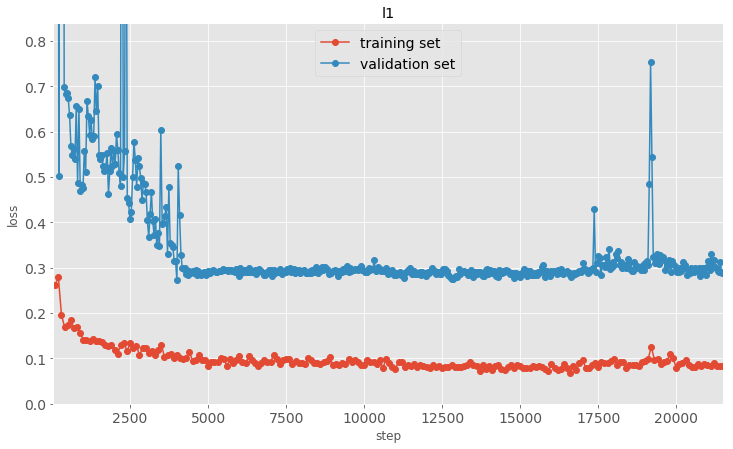

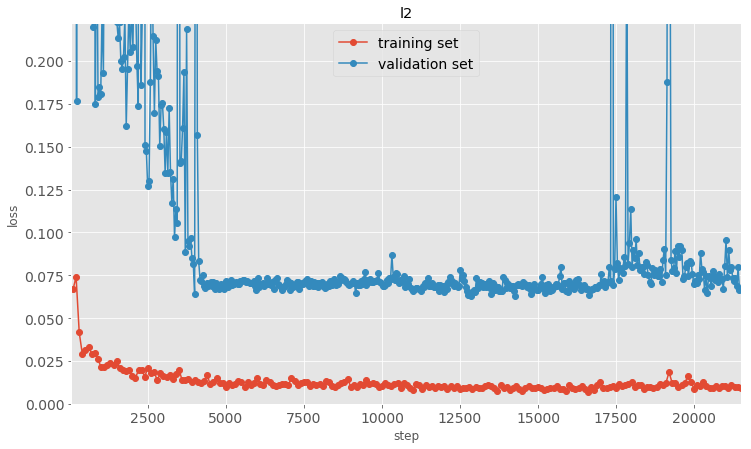

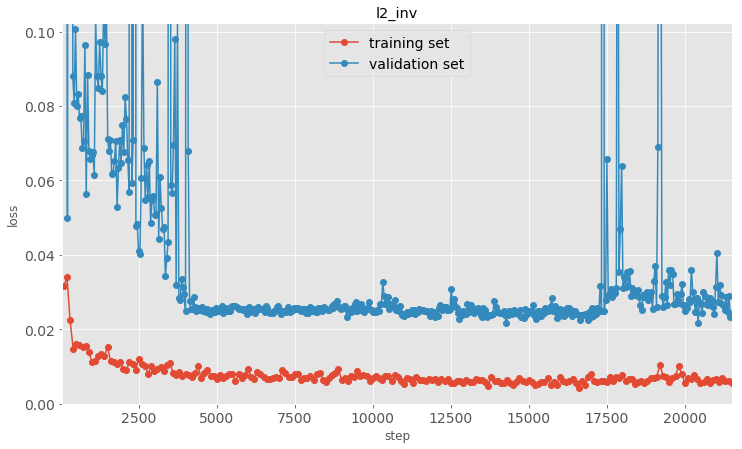

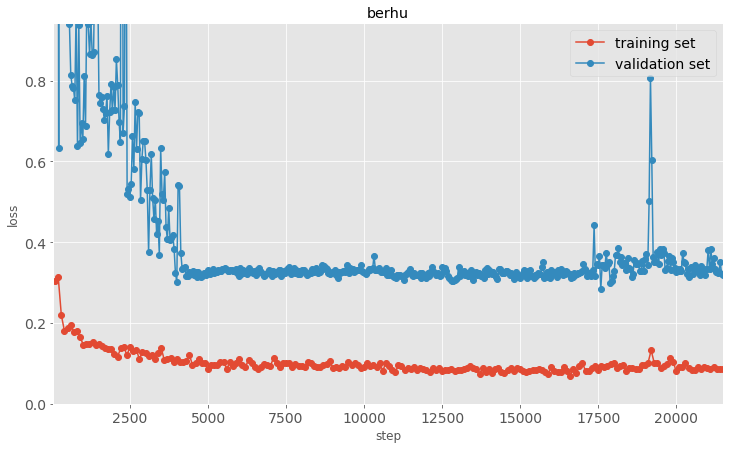

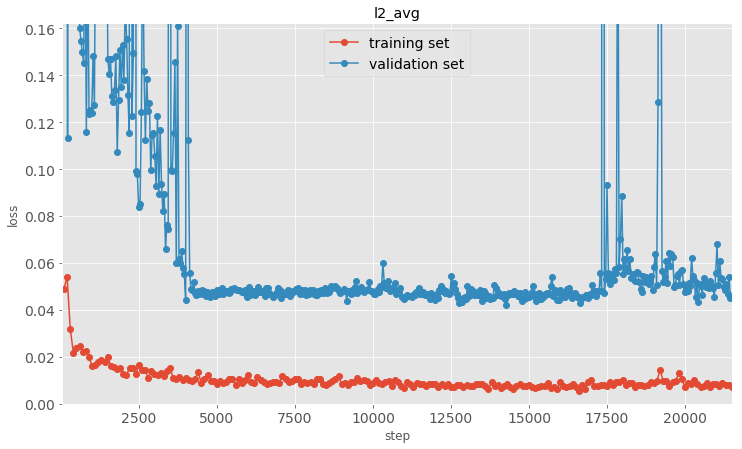

In [25]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_deconv_decoder_reduced')
dfs_train_resnet_v1_50_deconv_decoder_reduced, dfs_valid_resnet_v1_50_deconv_decoder_reduced = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_reduced,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_reduced)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_reduced, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_reduced, logy=False, ylim_scale=3)

## VGG-16 narihira2015 (2 scale, reduced parameters):

Training loss:
df_l1 (step: 12300): 0.06264 <-> corresponding valid loss: 0.31049 (step: 12298)
df_l2 (step: 12300): 0.00503 <-> corresponding valid loss: 0.08334 (step: 12298)
df_l2_inv (step: 12300): 0.00307 <-> corresponding valid loss: 0.03294 (step: 12298)
df_berhu (step: 12300): 0.06343 <-> corresponding valid loss: 0.35058 (step: 12298)
df_l2_avg (step: 12300): 0.00405 <-> corresponding valid loss: 0.05814 (step: 12298)

Validation loss:
df_l1 (step: 12771): 0.28845 <-> corresponding train loss: 0.07636 (step: 12800)
df_l2 (step: 12771): 0.07305 <-> corresponding train loss: 0.00708 (step: 12800)
df_l2_inv (step: 12771): 0.02963 <-> corresponding train loss: 0.00416 (step: 12800)
df_berhu (step: 12771): 0.32275 <-> corresponding train loss: 0.07746 (step: 12800)
df_l2_avg (step: 12771): 0.05134 <-> corresponding train loss: 0.00562 (step: 12800)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


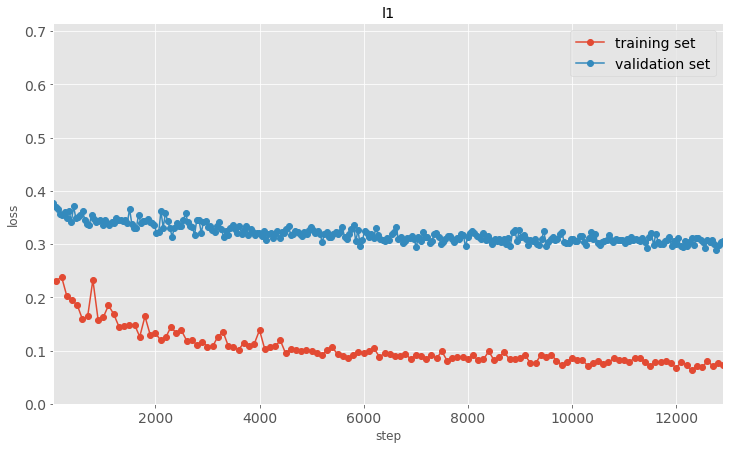

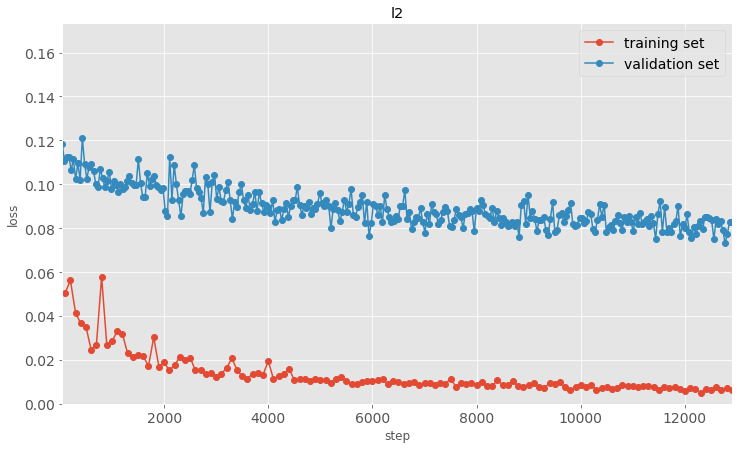

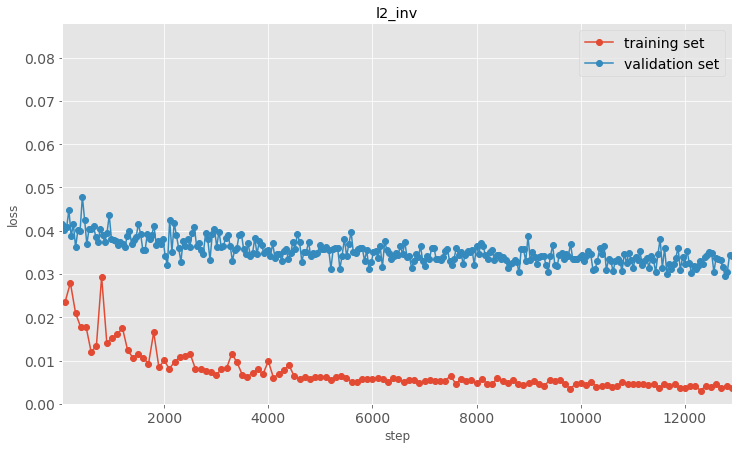

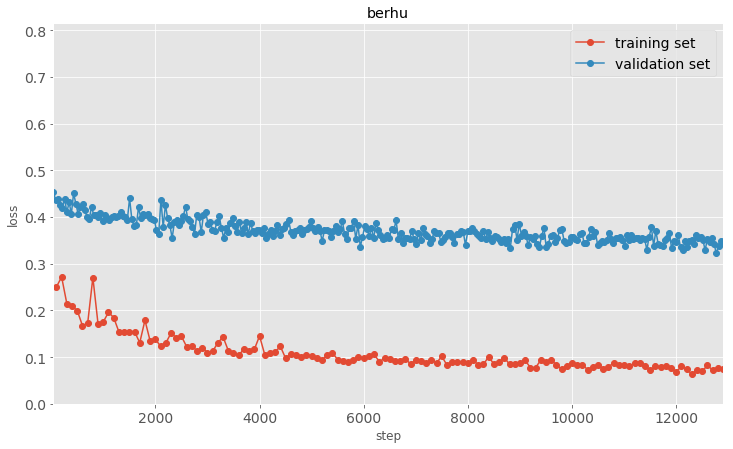

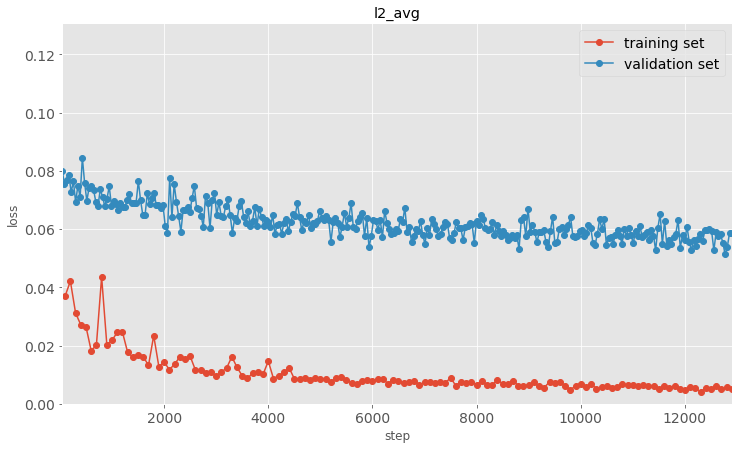

In [24]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_narihira2015_reduced_bn')
dfs_train_vgg16_narihira2015_reduced_bn, dfs_valid_vgg16_narihira2015_reduced_bn = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_narihira2015_reduced_bn,
                 dfdict_valid=dfs_valid_vgg16_narihira2015_reduced_bn)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_narihira2015_reduced_bn, 
                    dfs_valid=dfs_valid_vgg16_narihira2015_reduced_bn, logy=False, ylim_scale=3)

## VGG-16 deconv decoder (1 scale, reduced parameters, bn):

Training loss:
df_l1 (step: 11400): 0.08655 <-> corresponding valid loss: 0.30151 (step: 11395)
df_l2 (step: 11400): 0.01065 <-> corresponding valid loss: 0.07859 (step: 11395)
df_l2_inv (step: 11400): 0.00690 <-> corresponding valid loss: 0.03120 (step: 11395)
df_berhu (step: 11400): 0.08974 <-> corresponding valid loss: 0.34865 (step: 11395)
df_l2_avg (step: 11400): 0.00877 <-> corresponding valid loss: 0.05490 (step: 11395)

Validation loss:
df_l1 (step: 11481): 0.28914 <-> corresponding train loss: 0.09907 (step: 11500)
df_l2 (step: 11481): 0.07362 <-> corresponding train loss: 0.01302 (step: 11500)
df_l2_inv (step: 8600): 0.02909 <-> corresponding train loss: 0.00873 (step: 8600)
df_berhu (step: 8600): 0.33092 <-> corresponding train loss: 0.11232 (step: 8600)
df_l2_avg (step: 8600): 0.05149 <-> corresponding train loss: 0.01164 (step: 8600)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


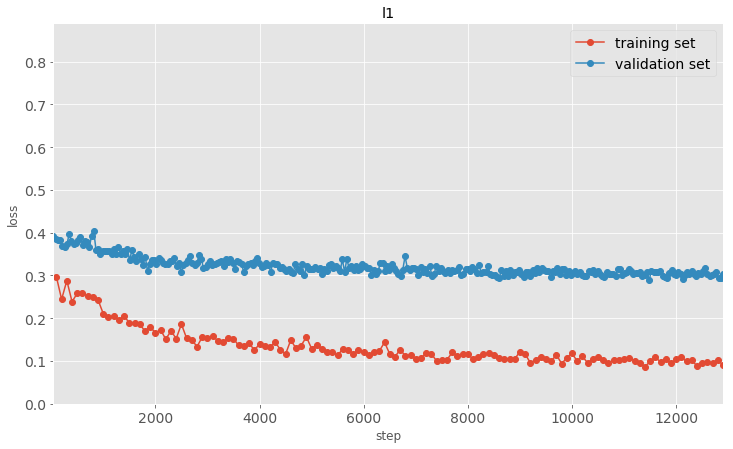

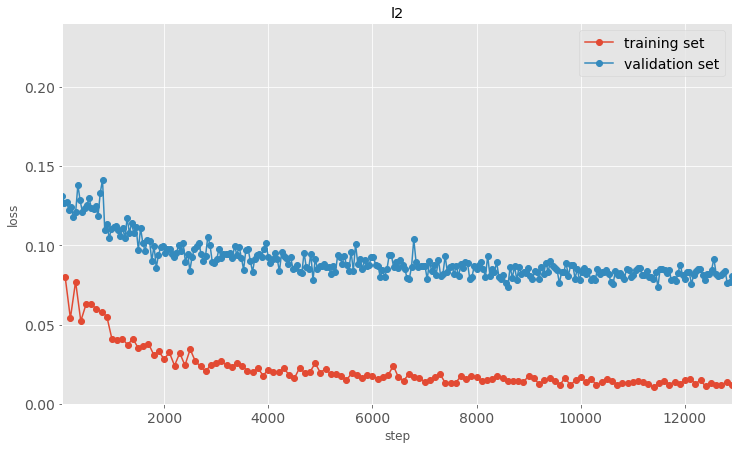

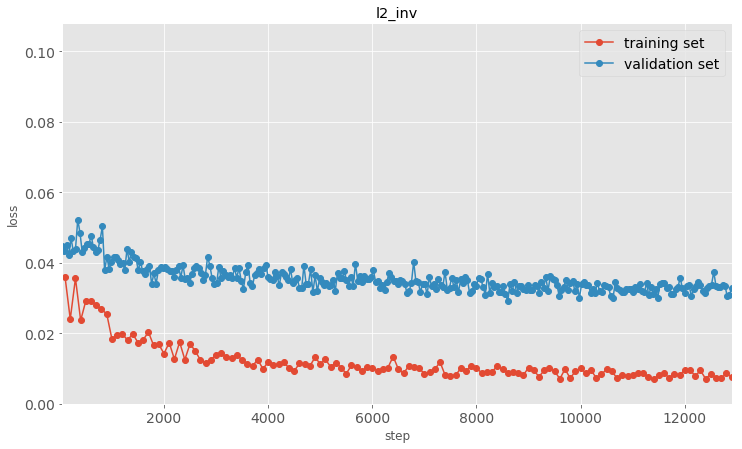

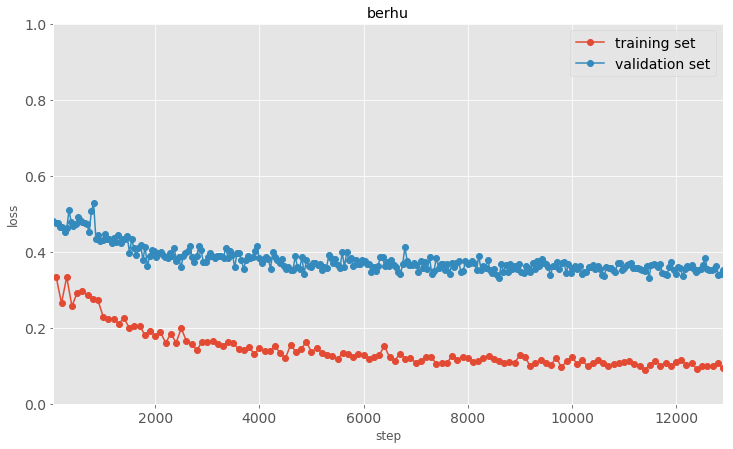

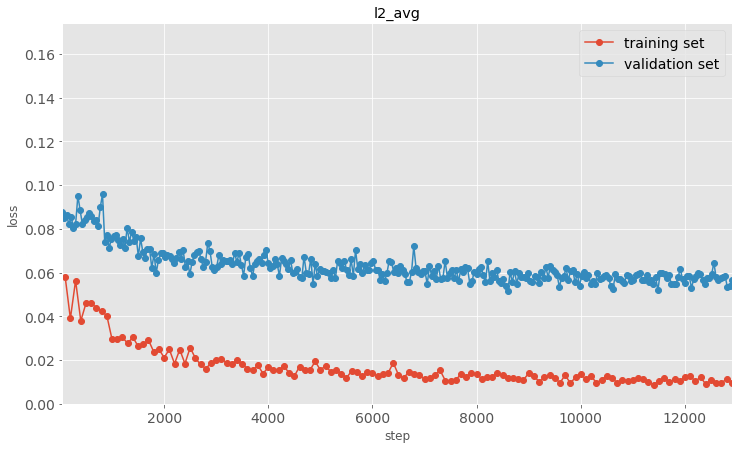

In [23]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_deconv_decoder_reduced_bn')
dfs_train_vgg16_deconv_decoder_reduced_bn, dfs_valid_vgg16_deconv_decoder_reduced_bn = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_deconv_decoder_reduced_bn,
                 dfdict_valid=dfs_valid_vgg16_deconv_decoder_reduced_bn)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_deconv_decoder_reduced_bn, 
                    dfs_valid=dfs_valid_vgg16_deconv_decoder_reduced_bn, logy=False, ylim_scale=3)

## Resnet-50 narihira2015 (2 scale):

Training loss:
df_l1 (step: 600): 0.11198 <-> corresponding valid loss: 0.38910 (step: 602)
df_l2 (step: 600): 0.01449 <-> corresponding valid loss: 0.11855 (step: 602)
df_l2_inv (step: 600): 0.00820 <-> corresponding valid loss: 0.03995 (step: 602)
df_berhu (step: 600): 0.11570 <-> corresponding valid loss: 0.46161 (step: 602)
df_l2_avg (step: 600): 0.01135 <-> corresponding valid loss: 0.07925 (step: 602)

Validation loss:
df_l1 (step: 602): 0.38910 <-> corresponding train loss: 0.11198 (step: 600)
df_l2 (step: 602): 0.11855 <-> corresponding train loss: 0.01449 (step: 600)
df_l2_inv (step: 602): 0.03995 <-> corresponding train loss: 0.00820 (step: 600)
df_berhu (step: 602): 0.46161 <-> corresponding train loss: 0.11570 (step: 600)
df_l2_avg (step: 602): 0.07925 <-> corresponding train loss: 0.01135 (step: 600)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


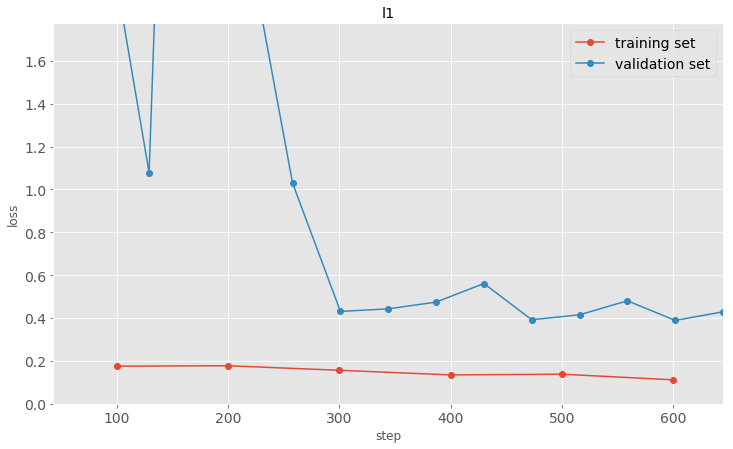

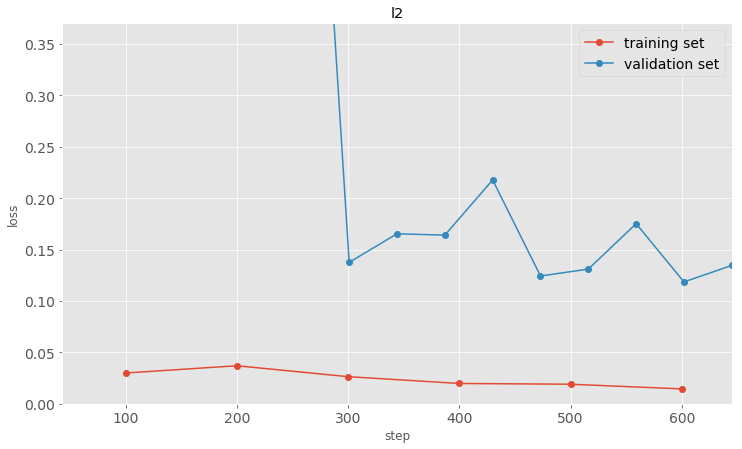

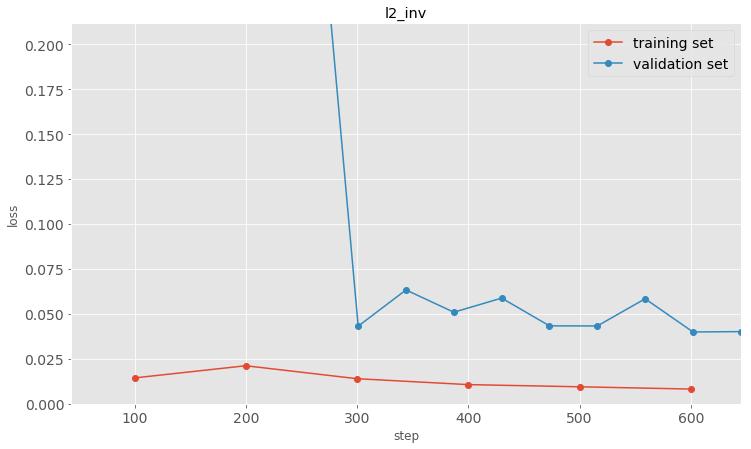

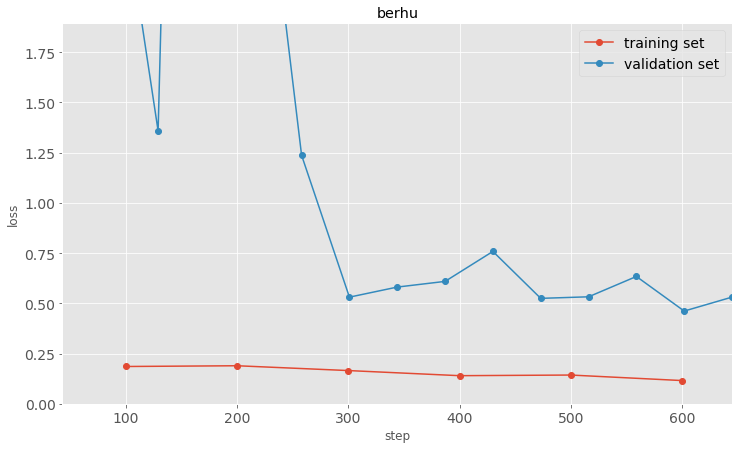

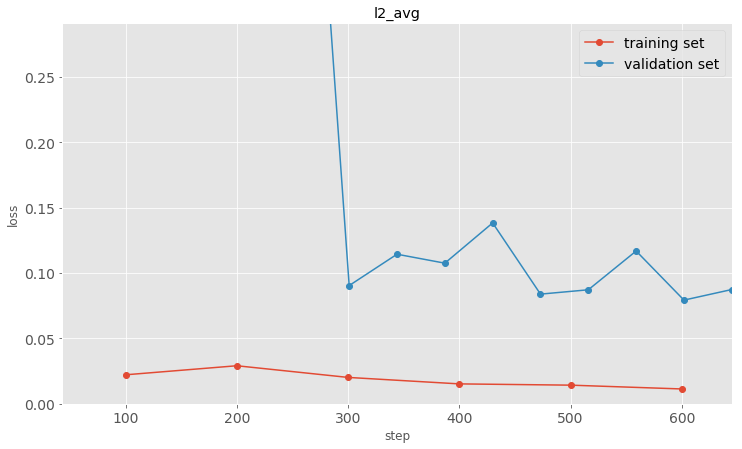

In [20]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_narihira2015')
dfs_train_resnet_v1_50_narihira2015, dfs_valid_resnet_v1_50_narihira2015 = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_narihira2015,
                 dfdict_valid=dfs_valid_resnet_v1_50_narihira2015)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_narihira2015, 
                    dfs_valid=dfs_valid_resnet_v1_50_narihira2015, 
                    logy=False, ylim_scale=10)

## Resnet-50 deconv decoder (1 scale):

Training loss:
df_l1 (step: 7900): 0.06269 <-> corresponding valid loss: 0.29473 (step: 7912)
df_l2 (step: 6300): 0.00589 <-> corresponding valid loss: 0.06638 (step: 6321)
df_l2_inv (step: 6300): 0.00388 <-> corresponding valid loss: 0.02339 (step: 6321)
df_berhu (step: 7900): 0.06393 <-> corresponding valid loss: 0.33038 (step: 7912)
df_l2_avg (step: 6300): 0.00488 <-> corresponding valid loss: 0.04488 (step: 6321)

Validation loss:
df_l1 (step: 8514): 0.27598 <-> corresponding train loss: 0.07868 (step: 8500)
df_l2 (step: 8514): 0.06334 <-> corresponding train loss: 0.00855 (step: 8500)
df_l2_inv (step: 4085): 0.02283 <-> corresponding train loss: 0.00607 (step: 4100)
df_berhu (step: 8514): 0.30342 <-> corresponding train loss: 0.08040 (step: 8500)
df_l2_avg (step: 8514): 0.04343 <-> corresponding train loss: 0.00700 (step: 8500)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


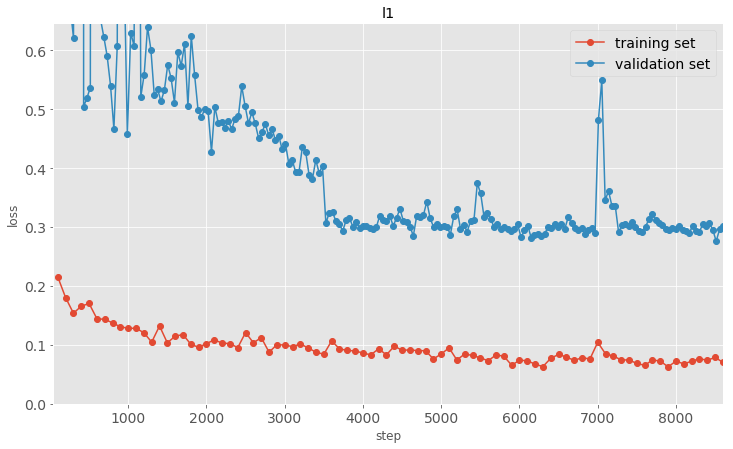

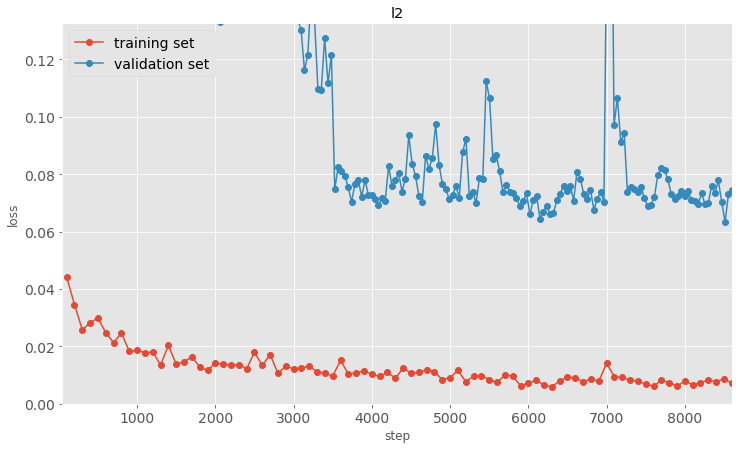

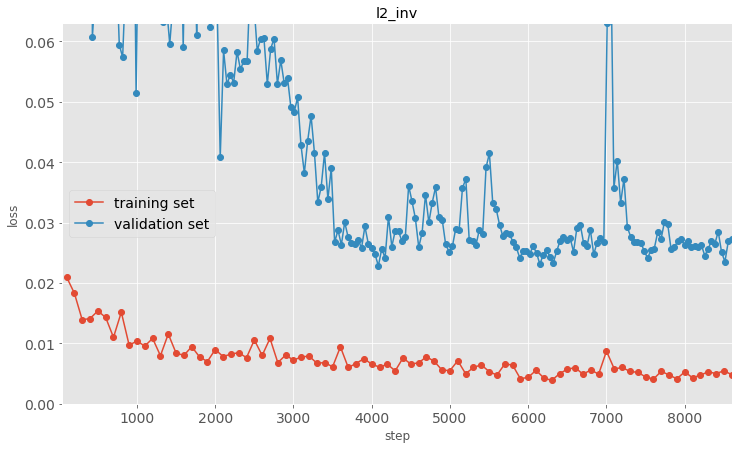

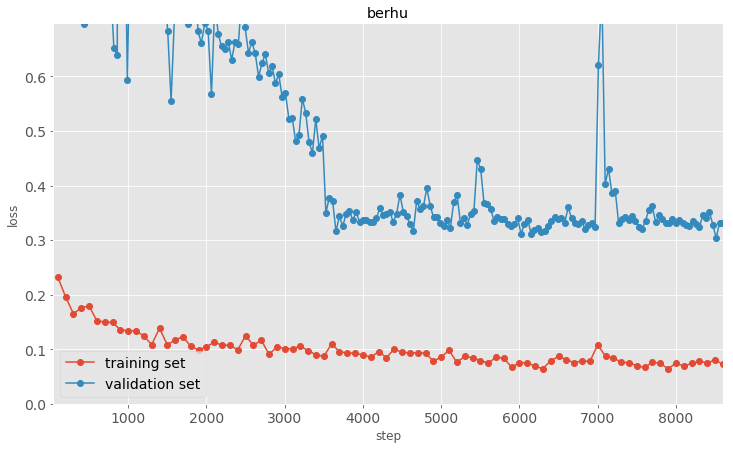

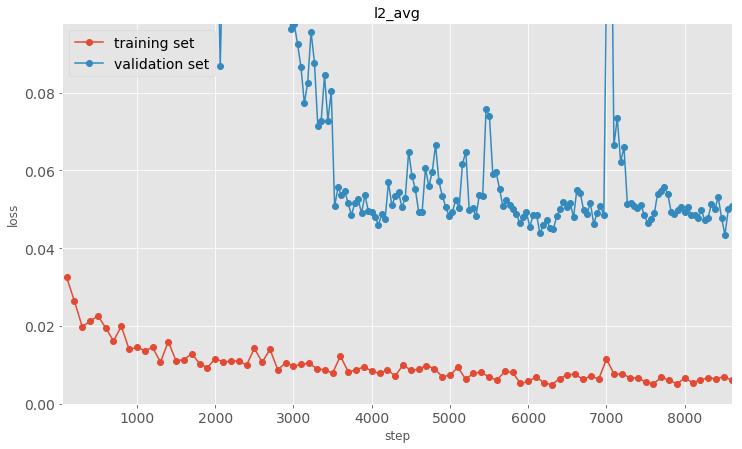

In [21]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_deconv_decoder')
dfs_train_resnet_v1_50_deconv_decoder, dfs_valid_resnet_v1_50_deconv_decoder = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder, logy=False, ylim_scale=3)

## VGG-16 Narihira2015 (2 scale):

Training loss:
df_l1 (step: 8400): 0.05335 <-> corresponding valid loss: 0.30025 (step: 8385)
df_l2 (step: 8400): 0.00407 <-> corresponding valid loss: 0.07606 (step: 8385)
df_l2_inv (step: 8400): 0.00265 <-> corresponding valid loss: 0.02773 (step: 8385)
df_berhu (step: 8400): 0.05397 <-> corresponding valid loss: 0.34866 (step: 8385)
df_l2_avg (step: 8400): 0.00336 <-> corresponding valid loss: 0.05189 (step: 8385)

Validation loss:
df_l1 (step: 1677): 0.28213 <-> corresponding train loss: 0.11423 (step: 1700)
df_l2 (step: 1677): 0.06628 <-> corresponding train loss: 0.01483 (step: 1700)
df_l2_inv (step: 1677): 0.02308 <-> corresponding train loss: 0.00828 (step: 1700)
df_berhu (step: 1677): 0.31713 <-> corresponding train loss: 0.11793 (step: 1700)
df_l2_avg (step: 1677): 0.04468 <-> corresponding train loss: 0.01155 (step: 1700)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


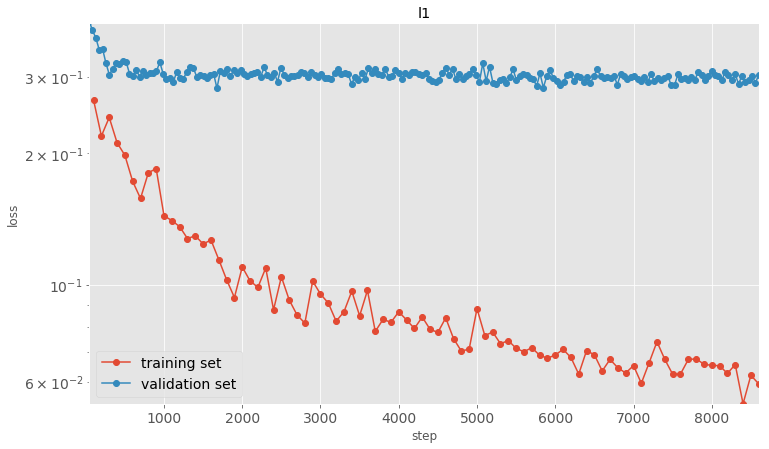

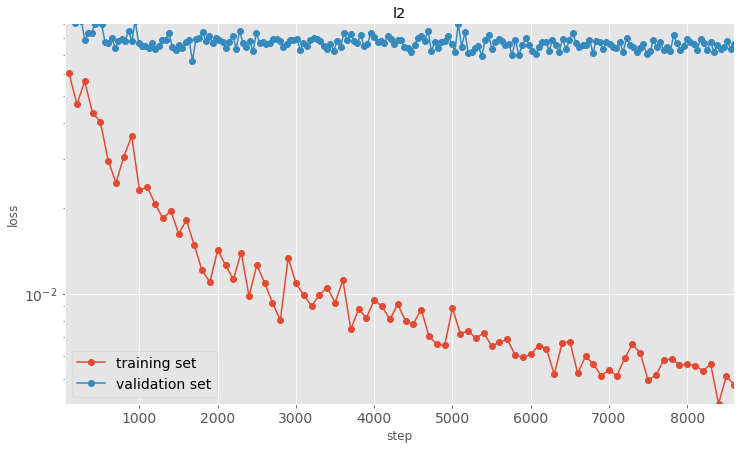

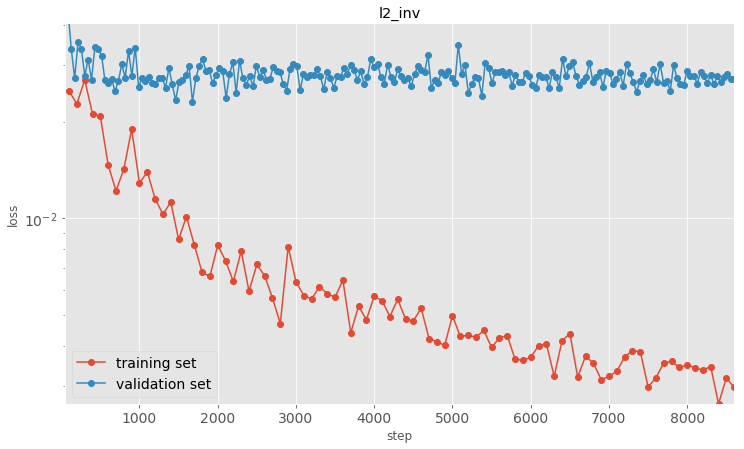

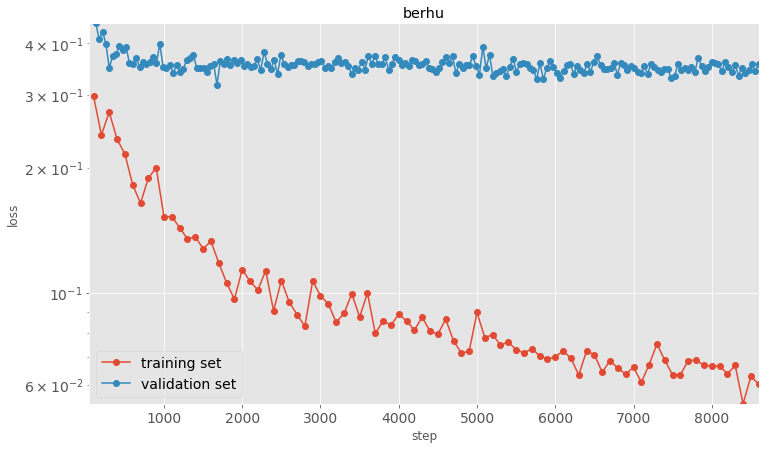

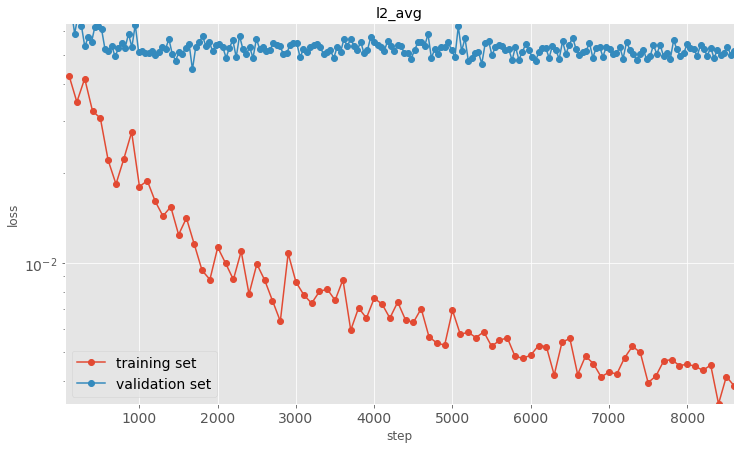

In [27]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_narihira2015')
dfs_train_vgg16_narihira2015, dfs_valid_vgg16_narihira2015 = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_narihira2015,
                 dfdict_valid=dfs_valid_vgg16_narihira2015)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_narihira2015, 
                    dfs_valid=dfs_valid_vgg16_narihira2015, 
                    logy=True, ylim_scale=1.5)

## VGG-16 deconv_decoder (1 scale):

Training loss:
df_l1 (step: 4300): 0.09377 <-> corresponding valid loss: 0.30771 (step: 4300)
df_l2 (step: 3900): 0.01164 <-> corresponding valid loss: 0.07764 (step: 3913)
df_l2_inv (step: 3900): 0.00714 <-> corresponding valid loss: 0.02797 (step: 3913)
df_berhu (step: 4200): 0.09723 <-> corresponding valid loss: 0.36274 (step: 4214)
df_l2_avg (step: 3900): 0.00939 <-> corresponding valid loss: 0.05281 (step: 3913)

Validation loss:
df_l1 (step: 3956): 0.29708 <-> corresponding train loss: 0.09580 (step: 4000)
df_l2 (step: 3956): 0.07398 <-> corresponding train loss: 0.01184 (step: 4000)
df_l2_inv (step: 2193): 0.02521 <-> corresponding train loss: 0.01024 (step: 2200)
df_berhu (step: 3655): 0.33850 <-> corresponding train loss: 0.10222 (step: 3700)
df_l2_avg (step: 3999): 0.05010 <-> corresponding train loss: 0.00954 (step: 4000)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


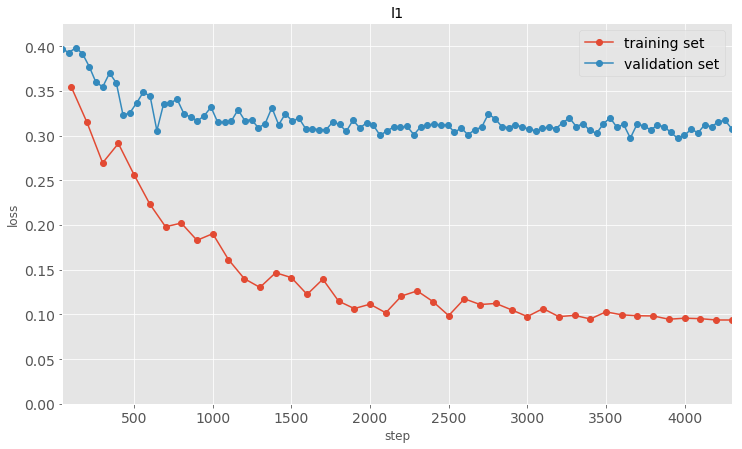

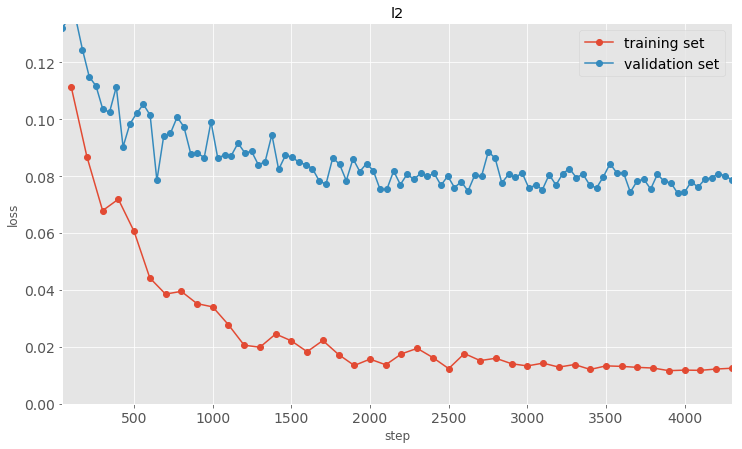

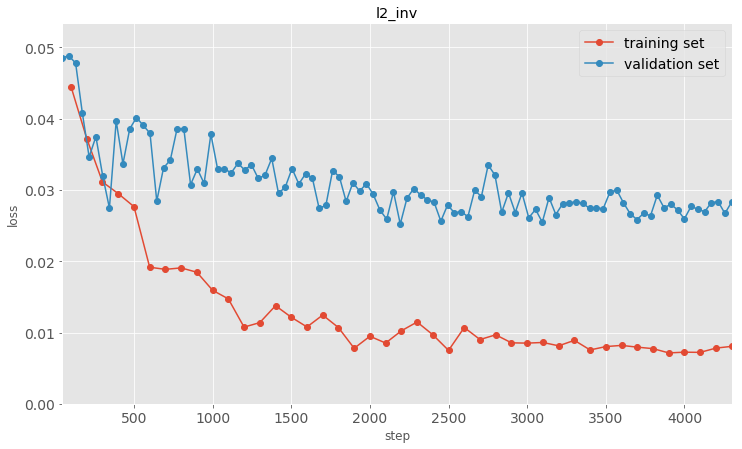

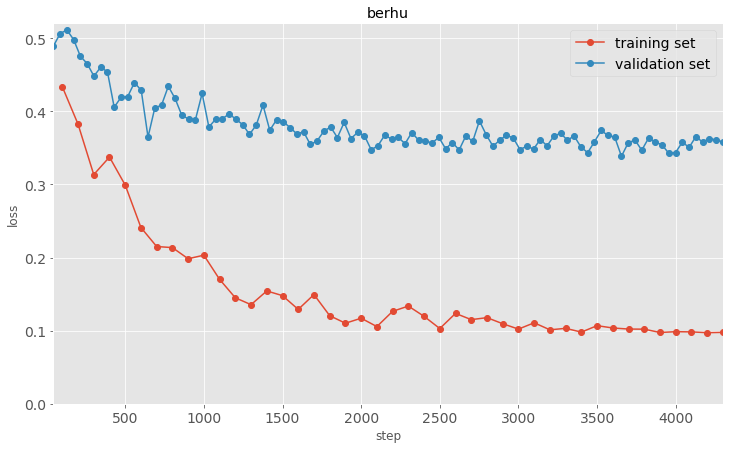

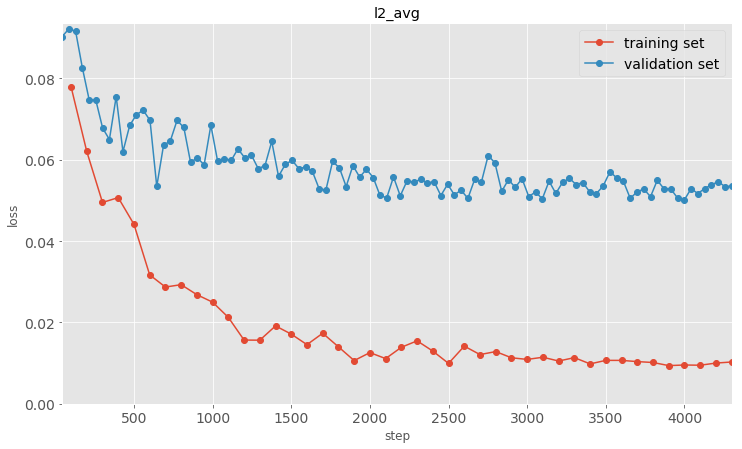

In [22]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_deconv_decoder')
dfs_train_vgg16_deconv_decoder, dfs_valid_vgg16_deconv_decoder = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_deconv_decoder,
                 dfdict_valid=dfs_valid_vgg16_deconv_decoder)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_deconv_decoder, 
                    dfs_valid=dfs_valid_vgg16_deconv_decoder, 
                    logy=False, ylim_scale=1.2)

# IIW

In [28]:
logs_data_path_iiw = logs_data_path + 'iiw/'

## Resnet-50 narihira2015 (2 scale, reduced parameters):
### lambda = 1.0 (mhdl) (based on deleted sintel model)

Training loss:
df_l1 (step: 7700): 0.03112 <-> corresponding valid loss: 0.06270 (step: 7672)
df_l2 (step: 7700): 0.00223 <-> corresponding valid loss: 0.00881 (step: 7672)
df_mhdl (step: 9200): 0.75899 <-> corresponding valid loss: 0.87698 (step: 9136)
df_l1_mwhdl (step: 9100): 0.52798 <-> corresponding valid loss: 0.65647 (step: 9136)
df_l2_mhdl (step: 9200): 0.76194 <-> corresponding valid loss: 0.88065 (step: 9136)
df_mwhdl (step: 9100): 0.49050 <-> corresponding valid loss: 0.61459 (step: 9136)
df_l1_mhdl (step: 9200): 0.79556 <-> corresponding valid loss: 0.91885 (step: 9136)
df_l2_mwhdl (step: 9100): 0.49345 <-> corresponding valid loss: 0.61826 (step: 9136)

Validation loss:
df_l1 (step: 9136): 0.04187 <-> corresponding train loss: 0.03748 (step: 9100)
df_l2 (step: 9136): 0.00367 <-> corresponding train loss: 0.00295 (step: 9100)
df_mhdl (step: 9380): 0.87654 <-> corresponding train loss: 0.99906 (step: 9300)
df_l1_mwhdl (step: 9136): 0.65647 <-> corresponding train loss: 0.527

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


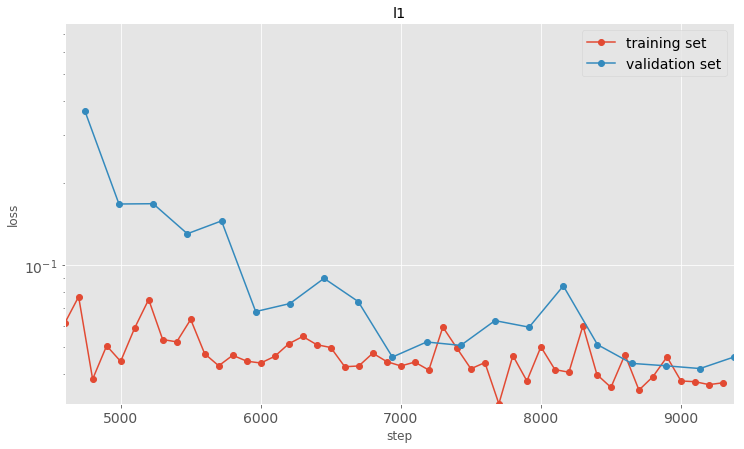

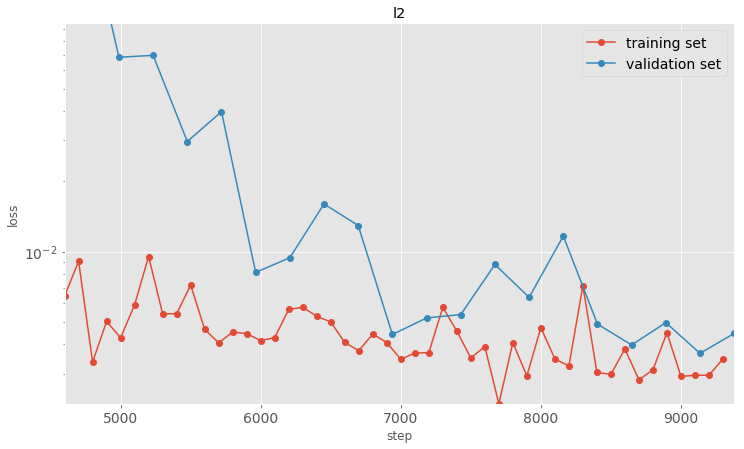

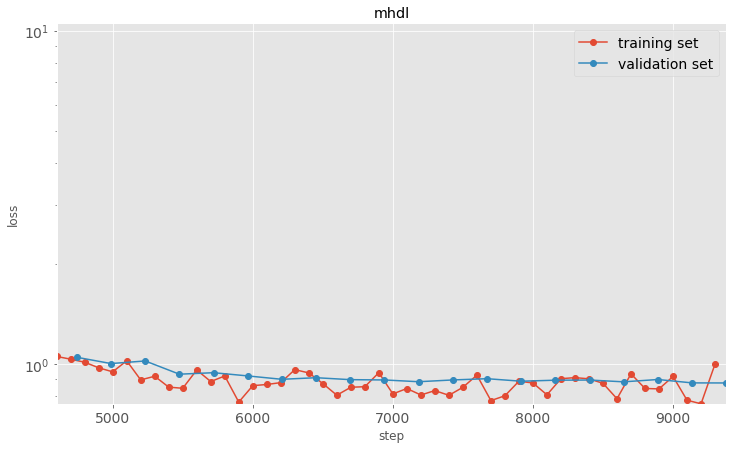

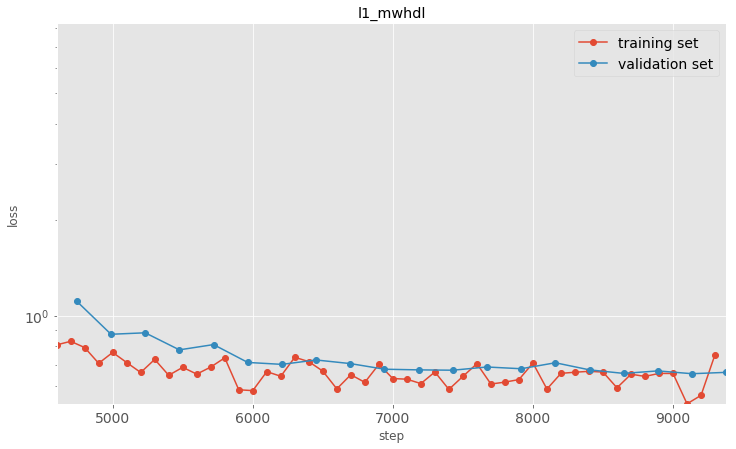

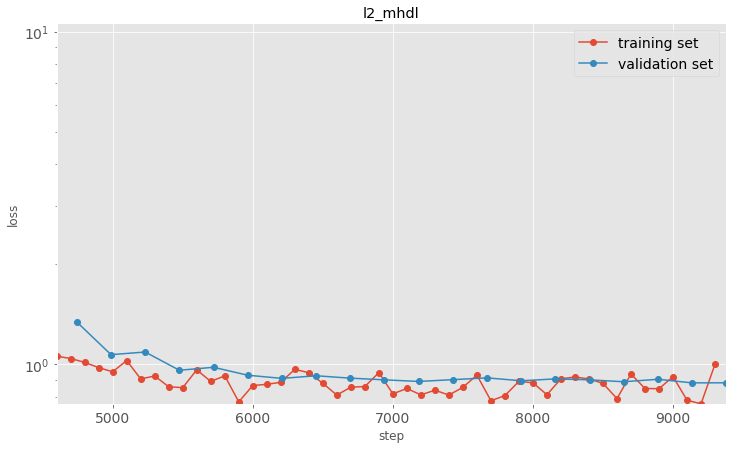

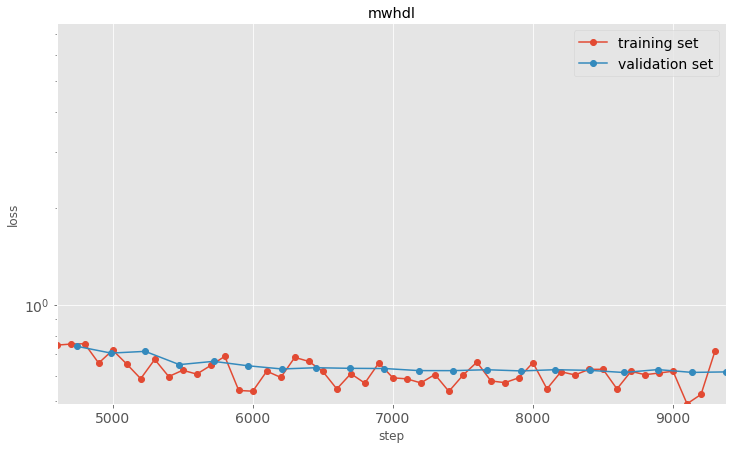

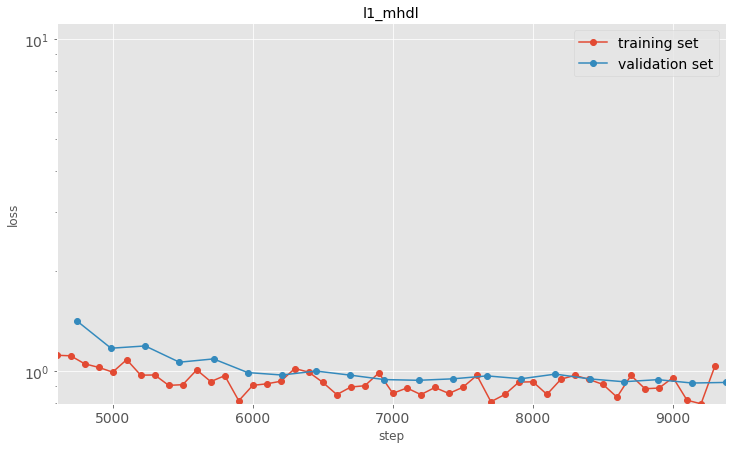

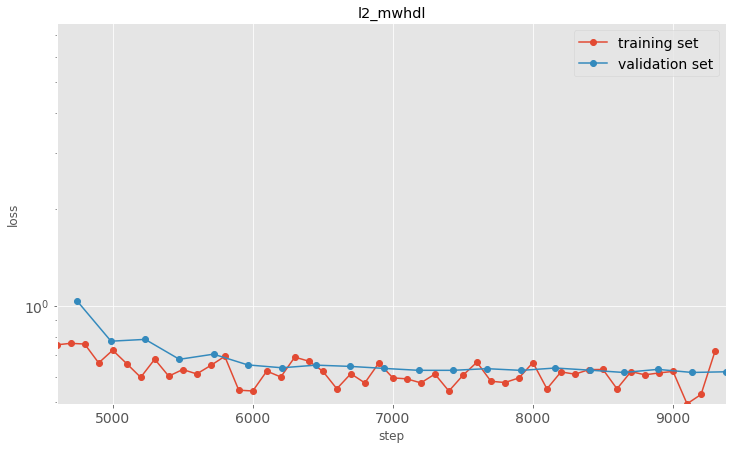

In [32]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l1_10mhdl')
dfs_train_resnet_v1_50_deconv_decoder_iiw, dfs_valid_resnet_v1_50_deconv_decoder_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_iiw,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_iiw, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw, 
                    logy=True, ylim_scale=10)

### lambda = 0.1 (mhdl) (based on sintel model 4300)

Training loss:
df_l1 (step: 6400): 0.03051 <-> corresponding valid loss: 0.06458 (step: 6496)
df_l2 (step: 6400): 0.00221 <-> corresponding valid loss: 0.00822 (step: 6496)
df_mhdl (step: 6300): 1.03650 <-> corresponding valid loss: 1.04492 (step: 6252)
df_l1_mwhdl (step: 5400): 0.10426 <-> corresponding valid loss: 0.12621 (step: 5520)
df_l2_mhdl (step: 5400): 0.10606 <-> corresponding valid loss: 0.11128 (step: 5520)
df_mwhdl (step: 4500): 0.62540 <-> corresponding valid loss: 0.76414 (step: 4544)
df_l1_mhdl (step: 6400): 0.13472 <-> corresponding valid loss: 0.16879 (step: 6496)
df_l2_mwhdl (step: 4500): 0.06874 <-> corresponding valid loss: 0.17397 (step: 4544)

Validation loss:
df_l1 (step: 6252): 0.03539 <-> corresponding train loss: 0.04098 (step: 6300)
df_l2 (step: 6252): 0.00286 <-> corresponding train loss: 0.00344 (step: 6300)
df_mhdl (step: 6740): 1.03749 <-> corresponding train loss: 1.04908 (step: 6700)
df_l1_mwhdl (step: 6252): 0.10989 <-> corresponding train loss: 0.120

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


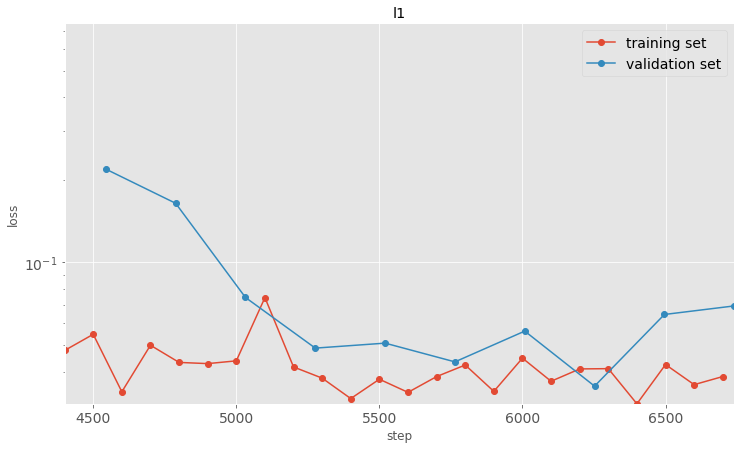

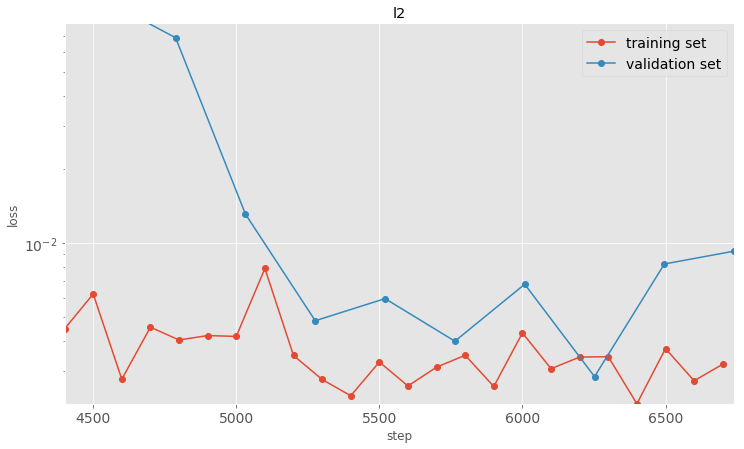

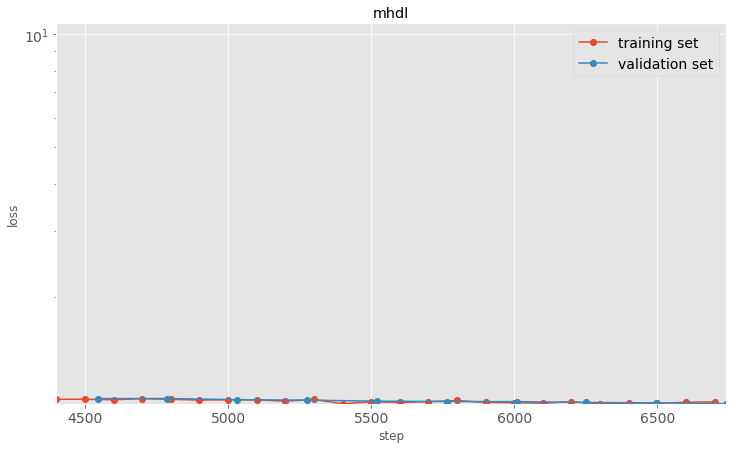

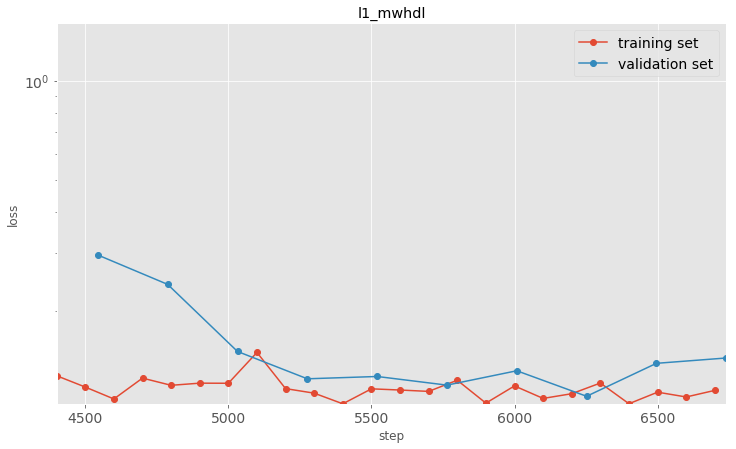

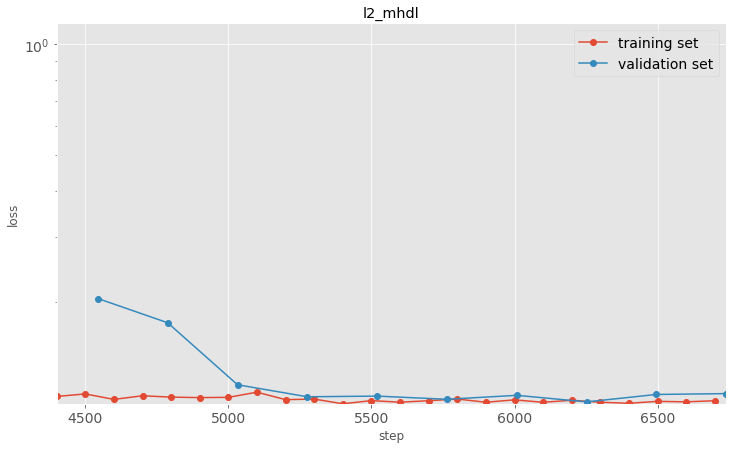

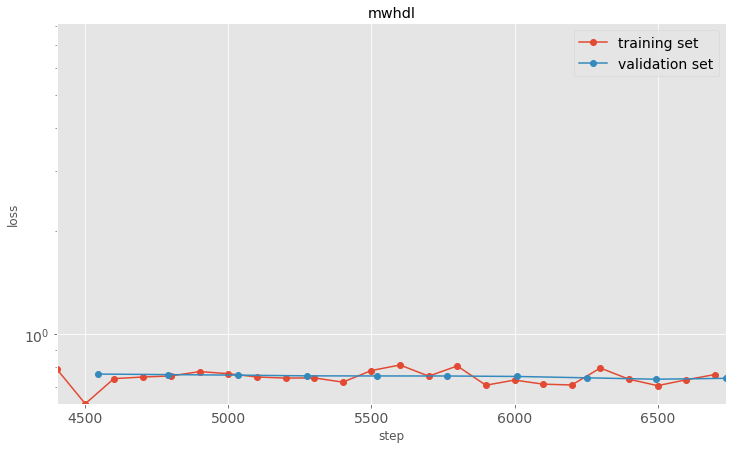

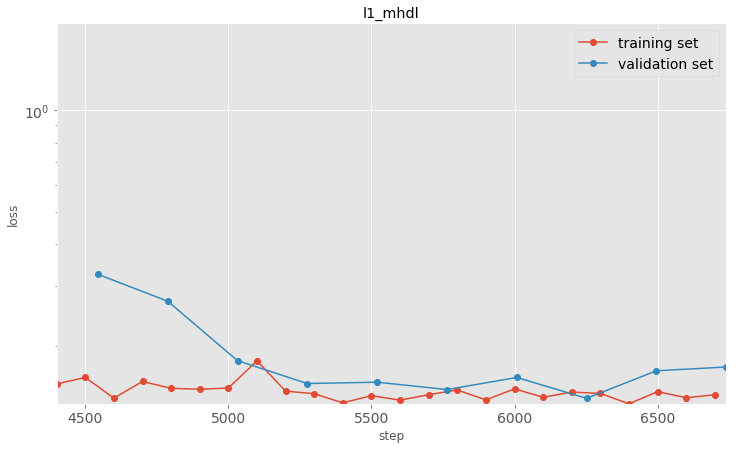

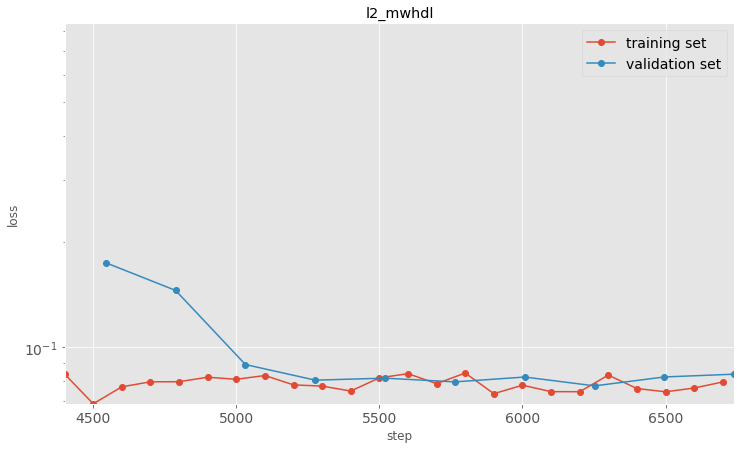

In [33]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l1_01mhdl')
dfs_train_iiw, dfs_valid_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_iiw,
                 dfdict_valid=dfs_valid_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_iiw, 
                    dfs_valid=dfs_valid_iiw, 
                    logy=True, ylim_scale=10)

## Resnet-50 deconv decoder (1 scale):
### lambda = 0.5 (mhdl)

Training loss:
df_l1 (step: 7900): 0.06149 <-> corresponding valid loss: 0.27628 (step: 8008)
df_l2 (step: 7900): 0.00910 <-> corresponding valid loss: 0.98829 (step: 8008)
df_mhdl (step: 7900): 0.79521 <-> corresponding valid loss: 1.09133 (step: 8008)
df_l1_mwhdl (step: 8400): 0.33305 <-> corresponding valid loss: 0.64022 (step: 8496)
df_l2_mhdl (step: 7900): 0.40670 <-> corresponding valid loss: 1.53395 (step: 8008)
df_mwhdl (step: 8400): 0.53156 <-> corresponding valid loss: 0.73895 (step: 8496)
df_l1_mhdl (step: 7900): 0.45909 <-> corresponding valid loss: 0.82195 (step: 8008)
df_l2_mwhdl (step: 8400): 0.27652 <-> corresponding valid loss: 57.43792 (step: 8496)

Validation loss:
df_l1 (step: 8252): 0.10679 <-> corresponding train loss: 0.06644 (step: 8300)
df_l2 (step: 8252): 0.02159 <-> corresponding train loss: 0.00964 (step: 8300)
df_mhdl (step: 8740): 0.90667 <-> corresponding train loss: 0.96790 (step: 8700)
df_l1_mwhdl (step: 8252): 0.42849 <-> corresponding train loss: 0.36

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


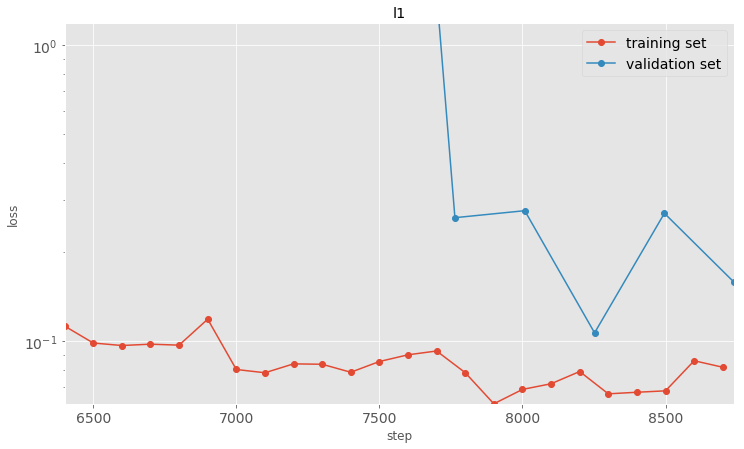

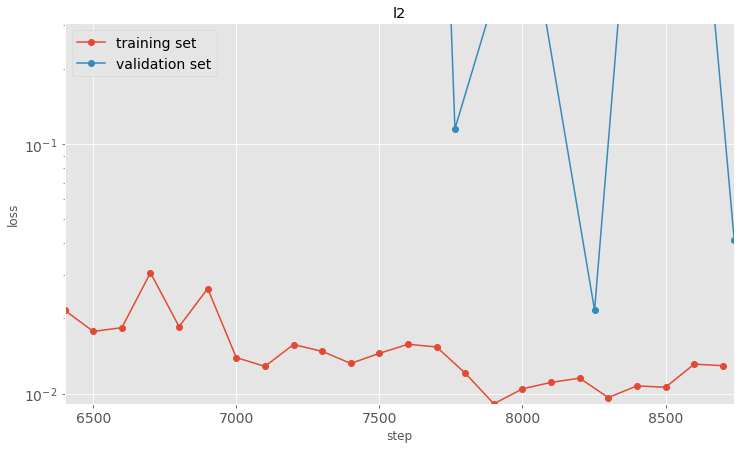

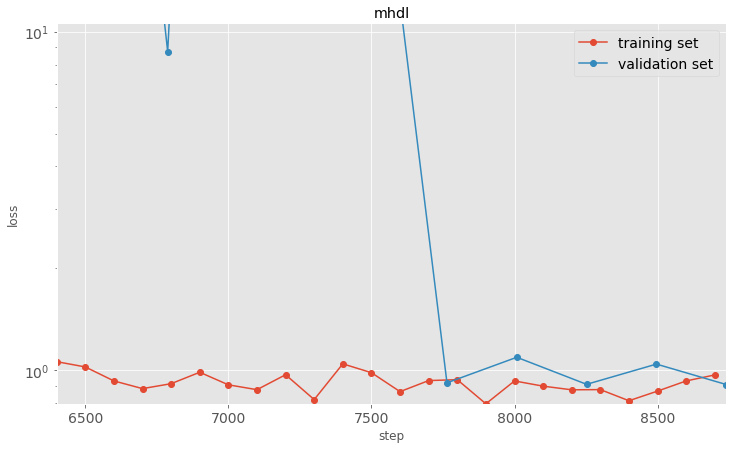

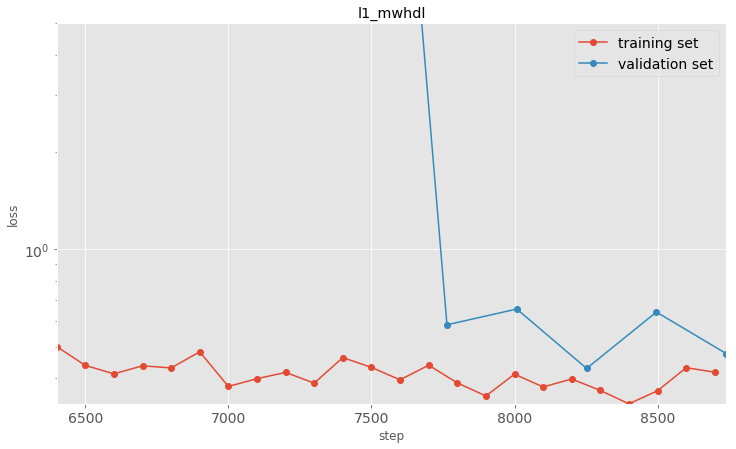

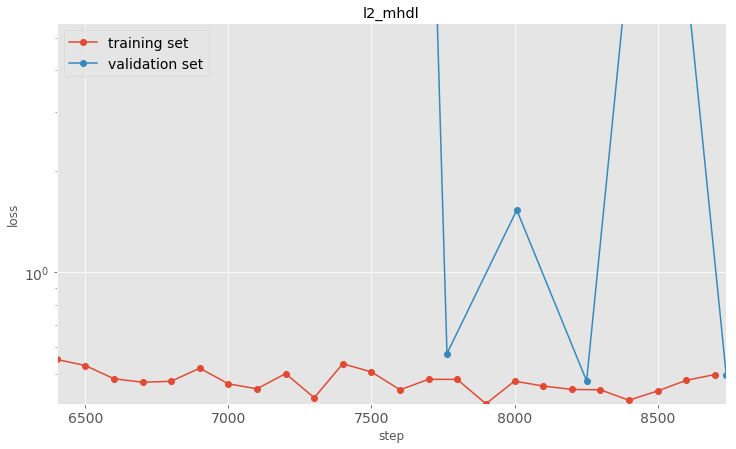

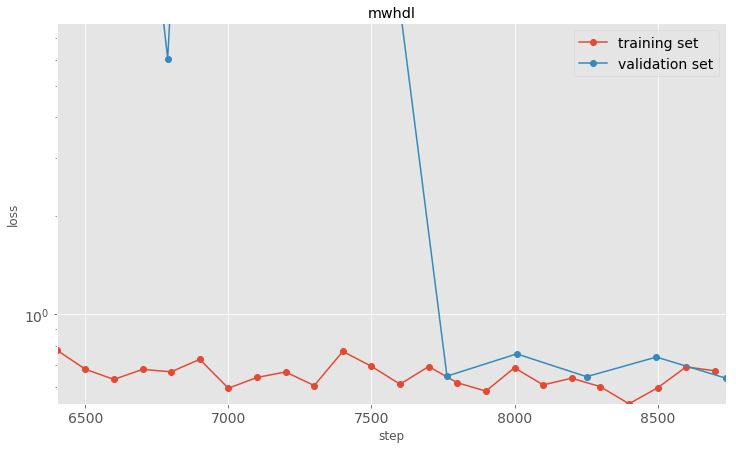

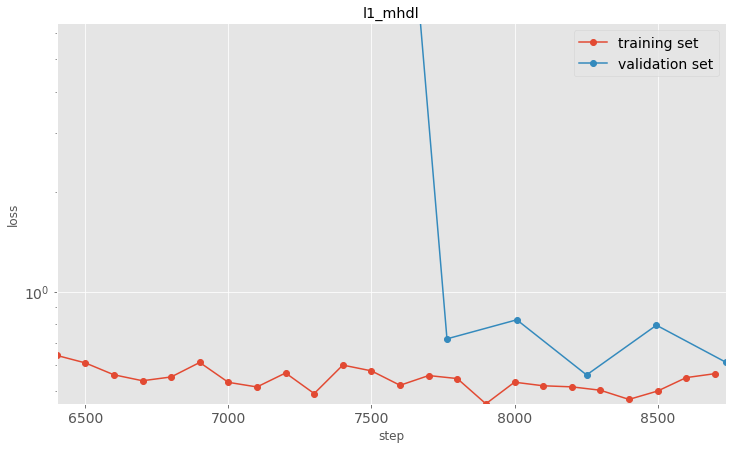

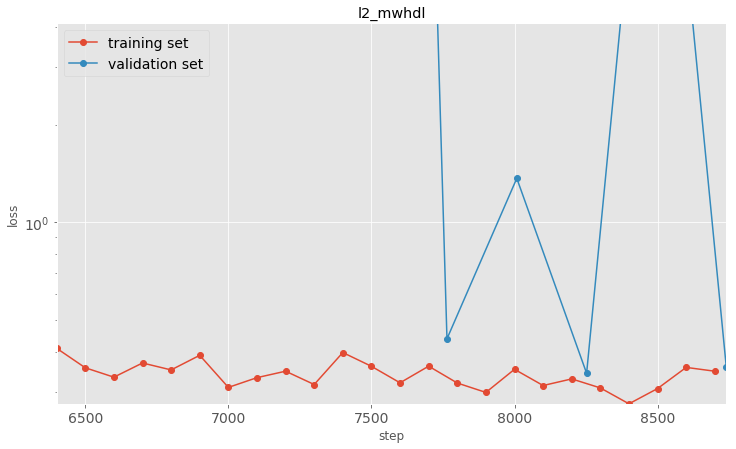

In [29]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_resnet_v1_50_deconv_decoder/l1_05mhdl')
dfs_train_resnet_v1_50_deconv_decoder_iiw, dfs_valid_resnet_v1_50_deconv_decoder_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_iiw,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_iiw, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw, 
                    logy=True, ylim_scale=10)

### lambda = 1.0 (mhdl)        

Training loss:
df_l1 (step: 8400): 0.05380 <-> corresponding valid loss: 0.07160 (step: 8496)
df_l2 (step: 8400): 0.00715 <-> corresponding valid loss: 0.05235 (step: 8496)
df_mhdl (step: 7700): 0.79028 <-> corresponding valid loss: 0.91040 (step: 7764)
df_l1_mwhdl (step: 8600): 0.60100 <-> corresponding valid loss: 0.69596 (step: 8496)
df_l2_mhdl (step: 7700): 0.80297 <-> corresponding valid loss: 0.93701 (step: 7764)
df_mwhdl (step: 8600): 0.53556 <-> corresponding valid loss: 0.62436 (step: 8496)
df_l1_mhdl (step: 7700): 0.85844 <-> corresponding valid loss: 1.02842 (step: 7764)
df_l2_mwhdl (step: 8600): 0.54650 <-> corresponding valid loss: 0.67670 (step: 8496)

Validation loss:
df_l1 (step: 8496): 0.07160 <-> corresponding train loss: 0.06060 (step: 8500)
df_l2 (step: 8252): 0.01380 <-> corresponding train loss: 0.01601 (step: 8300)
df_mhdl (step: 8496): 0.89498 <-> corresponding train loss: 0.92624 (step: 8500)
df_l1_mwhdl (step: 8496): 0.69596 <-> corresponding train loss: 0.716

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


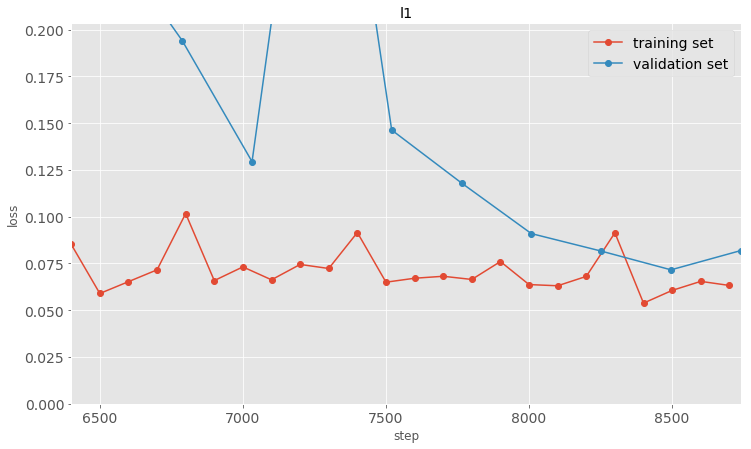

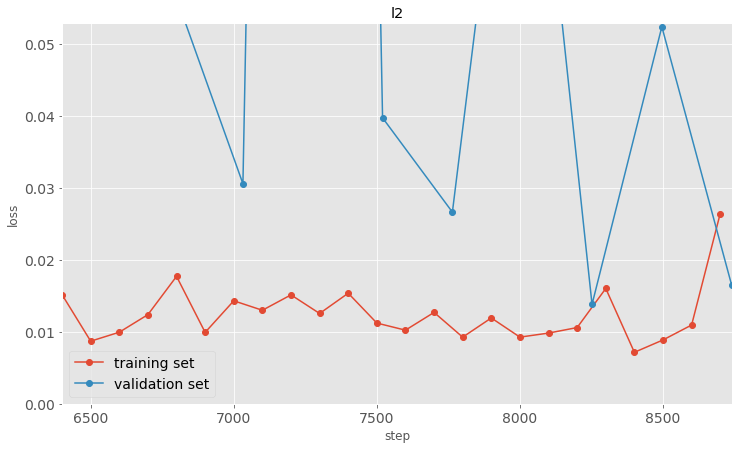

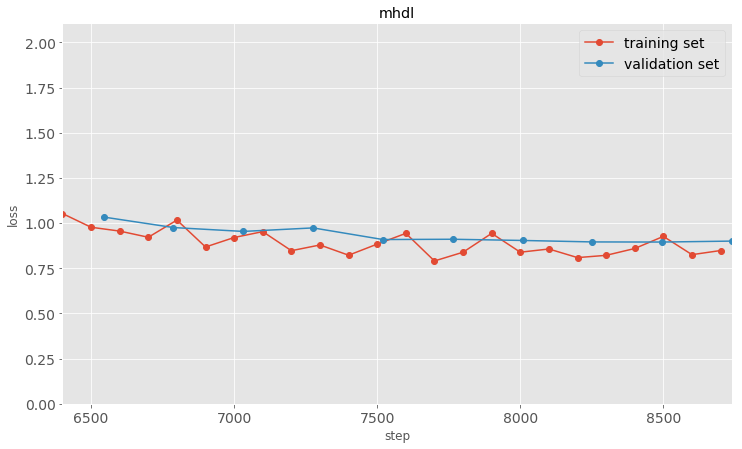

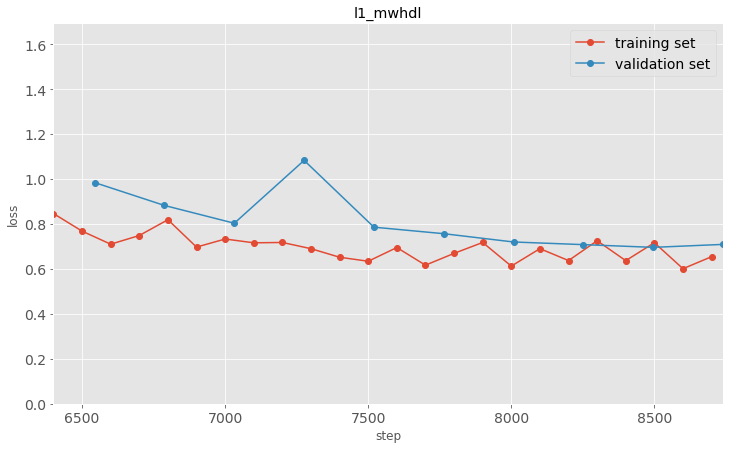

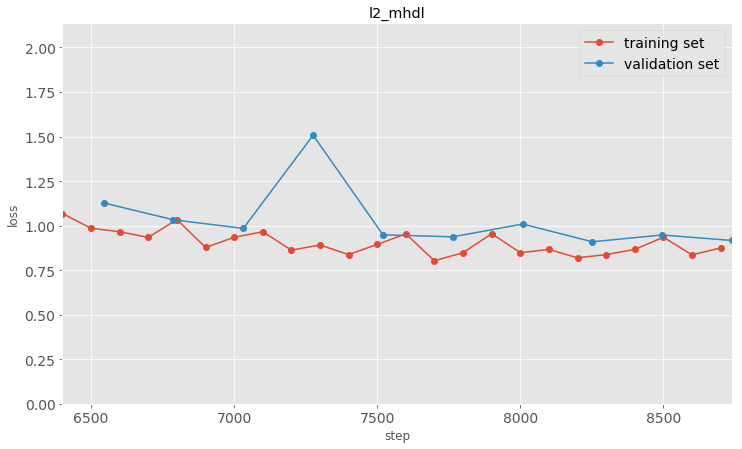

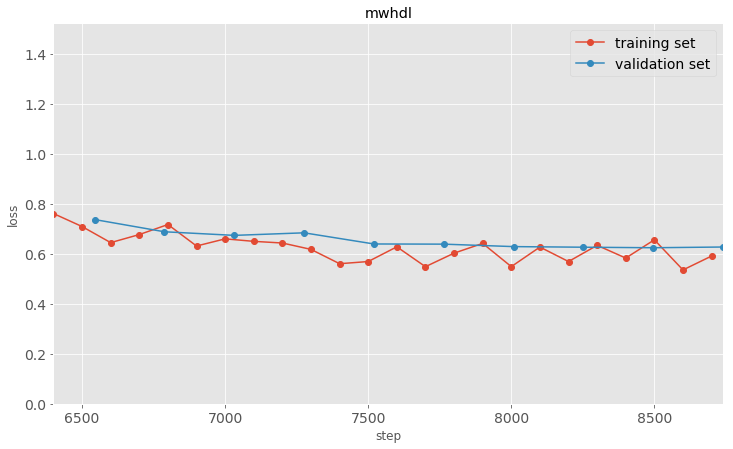

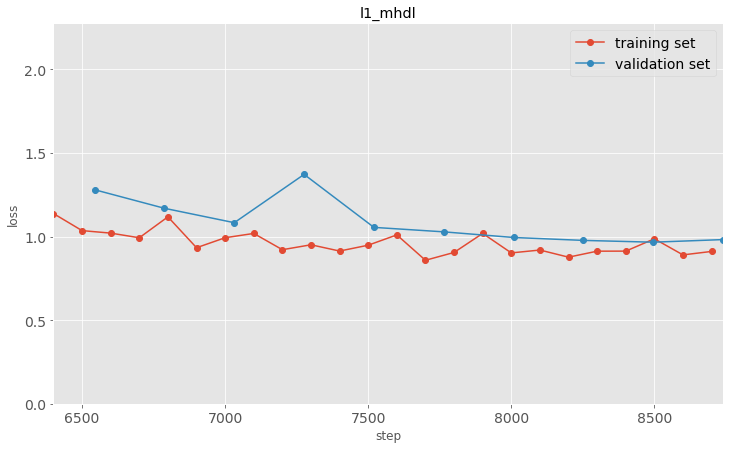

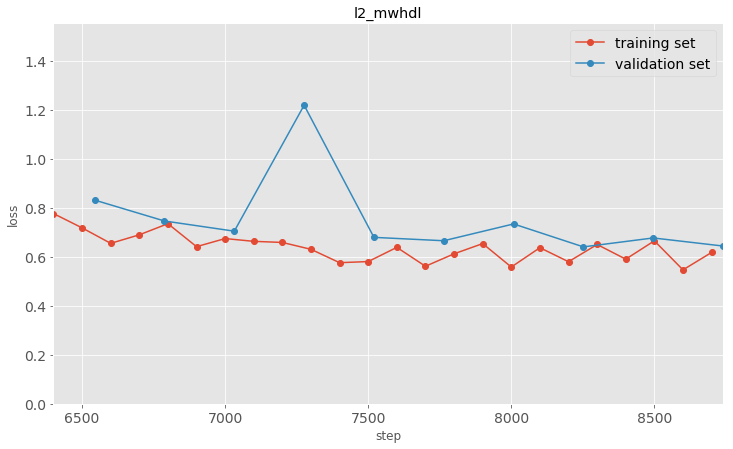

In [30]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_resnet_v1_50_deconv_decoder/l1_10mhdl',
                              exclude_sub_dirs=['2'])
dfs_train_resnet_v1_50_deconv_decoder_iiw, dfs_valid_resnet_v1_50_deconv_decoder_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_iiw,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_iiw, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw, 
                    logy=False, ylim_scale=2)

## vgg-16 narihira2015:

### lambda = 1.0 (mhdl)

Training loss:
df_l1 (step: 11500): 0.03229 <-> corresponding valid loss: 0.03840 (step: 11404)
df_l2 (step: 11500): 0.00250 <-> corresponding valid loss: 0.00351 (step: 11404)
df_mhdl (step: 11900): 0.77809 <-> corresponding valid loss: 0.89490 (step: 11892)
df_l1_mwhdl (step: 10600): 0.56677 <-> corresponding valid loss: 0.65285 (step: 10672)
df_l2_mhdl (step: 11900): 0.78126 <-> corresponding valid loss: 0.89805 (step: 11892)
df_mwhdl (step: 10600): 0.53061 <-> corresponding valid loss: 0.61567 (step: 10672)
df_l1_mhdl (step: 11900): 0.81410 <-> corresponding valid loss: 0.93022 (step: 11892)
df_l2_mwhdl (step: 10600): 0.53380 <-> corresponding valid loss: 0.61902 (step: 10672)

Validation loss:
df_l1 (step: 12380): 0.03531 <-> corresponding train loss: 0.03973 (step: 12300)
df_l2 (step: 12380): 0.00312 <-> corresponding train loss: 0.00392 (step: 12300)
df_mhdl (step: 12136): 0.87565 <-> corresponding train loss: 0.83274 (step: 12100)
df_l1_mwhdl (step: 12136): 0.65031 <-> correspo

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


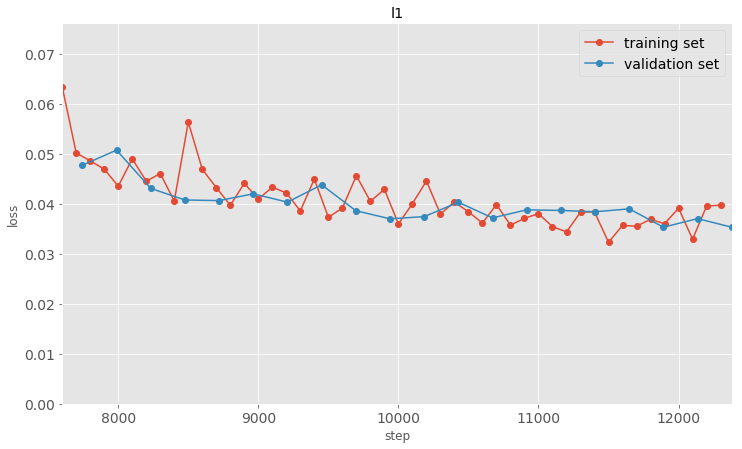

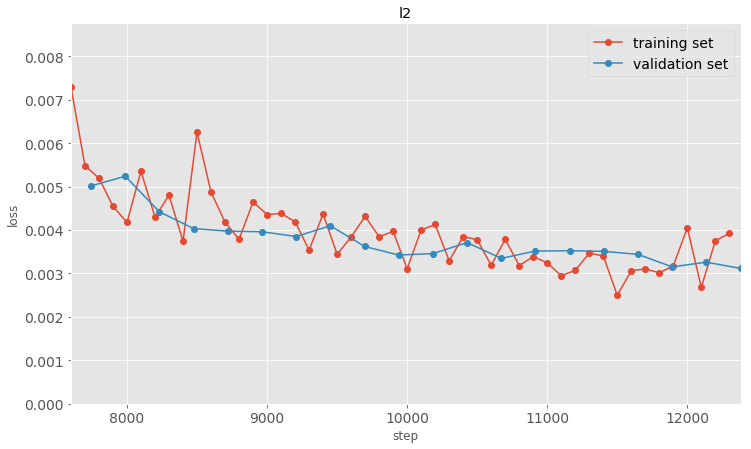

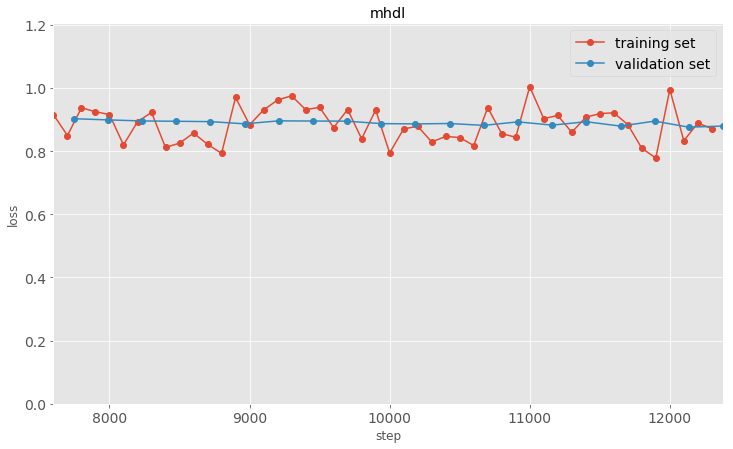

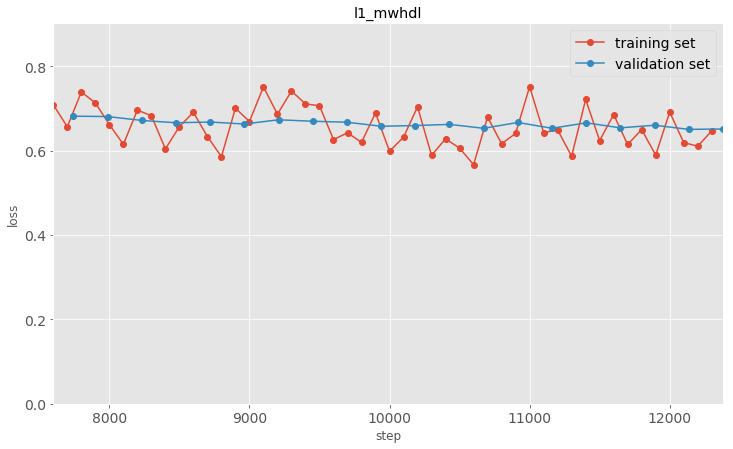

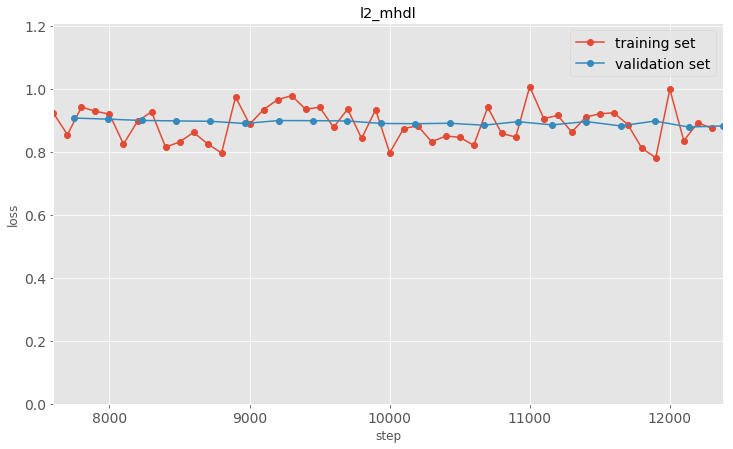

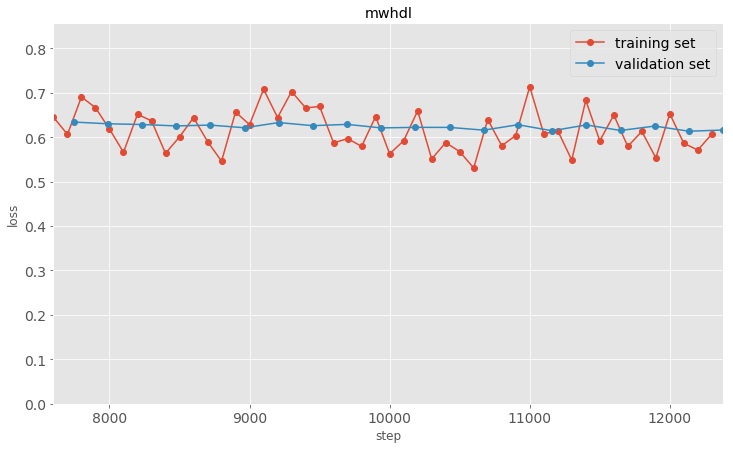

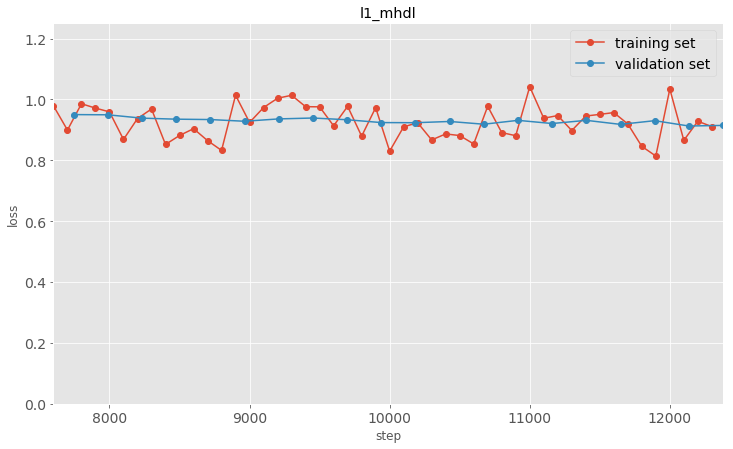

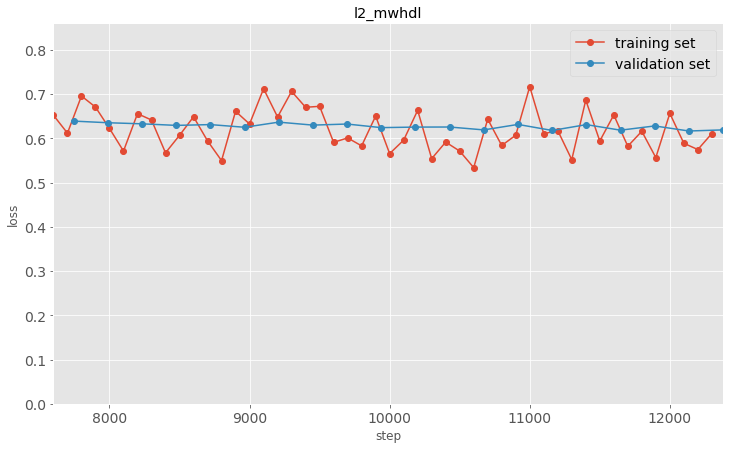

In [31]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_vgg16_narihira2015/l1_10mhdl',
                              exclude_sub_dirs=['2'])
dfs_train_vgg16_narihira2015_iiw, dfs_valid_vgg16_narihira2015_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_narihira2015_iiw,
                 dfdict_valid=dfs_valid_vgg16_narihira2015_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_narihira2015_iiw, 
                    dfs_valid=dfs_valid_vgg16_narihira2015_iiw, 
                    logy=False, ylim_scale=1.2)